In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.plotly as py
import plotly.graph_objs as go
import dask.dataframe as dd
from sklearn.cluster import KMeans
from scipy import linalg
from sklearn.mixture import GaussianMixture
from scipy import cluster
from sklearn.metrics import silhouette_score, calinski_harabaz_score
from scipy.spatial.distance import cdist, pdist
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler,Normalizer
from sklearn.decomposition import PCA
import sys



# 1. Data proprocessing

In [71]:
# Load the dataset
columns = [
       'guiAccess.homeid', 
       'guiAccess.userid', 
       'guiAccess.timestamp',
       'guiAccess.url',
       'guiAccess.browseTips.feedbackId',
       'guiAccess.browseTips.feedbackType', 
       'guiAccess.browseTips.index',
       'guiAccess.browseTips.questionSetId',
       'guiAccess.surveyPresentation.feedback.feedbackId',
       'guiAccess.surveyPresentation.feedback.feedbackType',
       'guiAccess.surveyPresentation.feedback.index',
       'guiAccess.surveyPresentation.feedback.questionSetId',
       'guiAccess.surveyPresentation.source',
       'guiAccess.tipPresentation.feedback.feedbackId',
       'guiAccess.tipPresentation.feedback.feedbackType',
       'guiAccess.tipPresentation.source',
       'guiAccess.gaugeToggle.displayCost',
       'guiAccess.gaugeToggle.sensor',
       'guiAccess.historicalChartDescription.compareEnd1',
       'guiAccess.historicalChartDescription.compareEnd2',
       'guiAccess.historicalChartDescription.compareStart1',
       'guiAccess.historicalChartDescription.compareStart2',
       'guiAccess.historicalChartDescription.dateIndex',
       'guiAccess.historicalChartDescription.displayCost',
       'guiAccess.historicalChartDescription.roomId',
       'guiAccess.historicalChartDescription.secondSensorType',
       'guiAccess.historicalChartDescription.sensorType',
       'guiAccess.historicalChartDescription.sensors', 
]

input_filename = '../clickdata_new.csv'
clickdata_dataset = pd.read_csv(input_filename, encoding='utf-8', usecols=columns, engine='python')

In [72]:
# Have a feeling about the data
clickdata_dataset.head()

,guiAccess.browseTips.feedbackId,guiAccess.browseTips.feedbackType,guiAccess.browseTips.index,guiAccess.browseTips.questionSetId,guiAccess.gaugeToggle.displayCost,guiAccess.gaugeToggle.sensor,guiAccess.historicalChartDescription.compareEnd1,guiAccess.historicalChartDescription.compareEnd2,guiAccess.historicalChartDescription.compareStart1,guiAccess.historicalChartDescription.compareStart2,...,guiAccess.surveyPresentation.feedback.feedbackType,guiAccess.surveyPresentation.feedback.index,guiAccess.surveyPresentation.feedback.questionSetId,guiAccess.surveyPresentation.source,guiAccess.timestamp,guiAccess.tipPresentation.feedback.feedbackId,guiAccess.tipPresentation.feedback.feedbackType,guiAccess.tipPresentation.source,guiAccess.url,guiAccess.userid
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2016-08-10 11:57:27,NaN,NaN,NaN,/welcome,Aisling
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2016-08-10 11:57:28,NaN,NaN,NaN,/readWeatherForecast/,Aisling
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2016-08-10 11:57:28,NaN,NaN,NaN,/readSensors/,Aisling
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2016-08-10 11:57:33,NaN,NaN,NaN,/readSensors/,Aisling
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2016-08-10 11:57:38,NaN,NaN,NaN,/readSensors/,Aisling


In [73]:
# Sort the data by userid first and then timestamp
clickdata_dataset['guiAccess.timestamp'] = pd.to_datetime(clickdata_dataset['guiAccess.timestamp'], errors='coerce')
clickdata_dataset = clickdata_dataset.sort_values(by=['guiAccess.userid','guiAccess.timestamp'])
clickdata_dataset = clickdata_dataset.reset_index(drop=True)
clickdata_dataset.head()

,guiAccess.browseTips.feedbackId,guiAccess.browseTips.feedbackType,guiAccess.browseTips.index,guiAccess.browseTips.questionSetId,guiAccess.gaugeToggle.displayCost,guiAccess.gaugeToggle.sensor,guiAccess.historicalChartDescription.compareEnd1,guiAccess.historicalChartDescription.compareEnd2,guiAccess.historicalChartDescription.compareStart1,guiAccess.historicalChartDescription.compareStart2,...,guiAccess.surveyPresentation.feedback.feedbackType,guiAccess.surveyPresentation.feedback.index,guiAccess.surveyPresentation.feedback.questionSetId,guiAccess.surveyPresentation.source,guiAccess.timestamp,guiAccess.tipPresentation.feedback.feedbackId,guiAccess.tipPresentation.feedback.feedbackType,guiAccess.tipPresentation.source,guiAccess.url,guiAccess.userid
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2017-04-25 06:26:10,NaN,NaN,NaN,/welcome,3bMcF56P1wWvJ82
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2017-04-25 06:26:12,NaN,NaN,NaN,/logGuiAccess,3bMcF56P1wWvJ82
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2017-04-25 06:26:12,NaN,NaN,NaN,/readWeatherForecast/,3bMcF56P1wWvJ82
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2017-04-25 06:26:12,NaN,NaN,NaN,/readSensors/,3bMcF56P1wWvJ82
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2017-04-25 06:26:17,NaN,NaN,NaN,/readSensors/,3bMcF56P1wWvJ82


In [74]:
# Insert a new column that represents sessions
clickdata_dataset.insert(0, 'session.id', value = 0) # column 0
# Insert a new column that records the time duration during a session
clickdata_dataset.insert(1, 'session.duration', value = 0) # column 1
# insert a new column that represents whether the historicalChartDescription field in this row is valid or not
clickdata_dataset.insert(2, 'histChartDesc.isValid', value = False) # column 2
# insert a new column that records the time the user spend in historicalChartDescription page (seconds)
clickdata_dataset.insert(3, 'histChartDesc.duration', value = 0) # column 3
# insert a new column that records the number of tips the user viewed
clickdata_dataset.insert(4, 'tips.count', value = 0) # column 4
# insert a new column that records the time the user spend in tips page (seconds)
clickdata_dataset.insert(5, 'tips.duration', value = 0) # column 5
# insert a new column that records the time the user spend in welcome page (seconds)
clickdata_dataset.insert(6, 'welcome.duration', value = 0) # column 5

In [75]:
clickdata_dataset.head()

,session.id,session.duration,histChartDesc.isValid,histChartDesc.duration,tips.count,tips.duration,welcome.duration,guiAccess.browseTips.feedbackId,guiAccess.browseTips.feedbackType,guiAccess.browseTips.index,...,guiAccess.surveyPresentation.feedback.feedbackType,guiAccess.surveyPresentation.feedback.index,guiAccess.surveyPresentation.feedback.questionSetId,guiAccess.surveyPresentation.source,guiAccess.timestamp,guiAccess.tipPresentation.feedback.feedbackId,guiAccess.tipPresentation.feedback.feedbackType,guiAccess.tipPresentation.source,guiAccess.url,guiAccess.userid
0,0,0,False,0,0,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2017-04-25 06:26:10,NaN,NaN,NaN,/welcome,3bMcF56P1wWvJ82
1,0,0,False,0,0,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2017-04-25 06:26:12,NaN,NaN,NaN,/logGuiAccess,3bMcF56P1wWvJ82
2,0,0,False,0,0,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2017-04-25 06:26:12,NaN,NaN,NaN,/readWeatherForecast/,3bMcF56P1wWvJ82
3,0,0,False,0,0,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2017-04-25 06:26:12,NaN,NaN,NaN,/readSensors/,3bMcF56P1wWvJ82
4,0,0,False,0,0,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2017-04-25 06:26:17,NaN,NaN,NaN,/readSensors/,3bMcF56P1wWvJ82


## 1.1 HistoricalChartDescription data

In [76]:
# Check the sessions that have valid historicalChartDescription data and calculate the time spent in this page
max_index = len(clickdata_dataset.index)
hist_index = clickdata_dataset[clickdata_dataset['guiAccess.historicalChartDescription.sensorType'].notnull()].index.tolist()
hist_index_1 = [x+1 if x+1 < max_index else x for x in hist_index ] 

for i,j in zip(hist_index, hist_index_1):
    time_start = clickdata_dataset.loc[i,'guiAccess.timestamp']
    time_end   = clickdata_dataset.loc[j,'guiAccess.timestamp']
    userid_start = clickdata_dataset.loc[i,'guiAccess.userid']
    userid_end = clickdata_dataset.loc[j,'guiAccess.userid']
    time_difference = time_end - time_start
    time_difference_in_minutes = time_difference / dt.timedelta(minutes=1)
    time_difference_in_seconds = time_difference / dt.timedelta(seconds=1)
    # if the time different is more then 10 minutes, system will log out automatically, so it is not in the same session
    # if the time different is more than 5 seconds, we assume that this record is valid since the user stays this page longer
    # the last condition is just double check
    if time_difference_in_minutes <= 10 and time_difference_in_seconds >= 5 and userid_start == userid_end:
        clickdata_dataset.loc[i, 'histChartDesc.isValid'] = True
        clickdata_dataset.loc[i, 'histChartDesc.duration'] = time_difference_in_seconds

In [77]:
clickdata_dataset[clickdata_dataset['histChartDesc.duration'] != 0].head()

,session.id,session.duration,histChartDesc.isValid,histChartDesc.duration,tips.count,tips.duration,welcome.duration,guiAccess.browseTips.feedbackId,guiAccess.browseTips.feedbackType,guiAccess.browseTips.index,...,guiAccess.surveyPresentation.feedback.feedbackType,guiAccess.surveyPresentation.feedback.index,guiAccess.surveyPresentation.feedback.questionSetId,guiAccess.surveyPresentation.source,guiAccess.timestamp,guiAccess.tipPresentation.feedback.feedbackId,guiAccess.tipPresentation.feedback.feedbackType,guiAccess.tipPresentation.source,guiAccess.url,guiAccess.userid
21,0,0,True,6.0,0,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2017-04-25 06:26:54,NaN,NaN,NaN,/userHistoryData,3bMcF56P1wWvJ82
123,0,0,True,5.0,0,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2017-05-07 09:18:01,NaN,NaN,NaN,/userHistoryData,9PkgfKWY6_aAs99
125,0,0,True,11.0,0,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2017-05-07 09:18:12,NaN,NaN,NaN,/userHistory/MONTH,9PkgfKWY6_aAs99
131,0,0,True,5.0,0,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2017-05-07 09:18:36,NaN,NaN,NaN,/userHistory/DAY_OF_WEEK,9PkgfKWY6_aAs99
132,0,0,True,14.0,0,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2017-05-07 09:18:41,NaN,NaN,NaN,/userHistory/HOUR,9PkgfKWY6_aAs99


## 1.2 Tips data

In [78]:
# count the number of tips the user viewed in each session
max_index = len(clickdata_dataset.index)
tips_index = clickdata_dataset[clickdata_dataset['guiAccess.browseTips.feedbackId'].notnull()].index.tolist()
tips_index_1 = tips_index[1:]
tips_index_1.insert(len(tips_index_1), tips_index[-1])

tips_count = 1

for (i,j) in zip(tips_index, tips_index_1):
    time_start = clickdata_dataset.loc[i,'guiAccess.timestamp']
    time_end   = clickdata_dataset.loc[j,'guiAccess.timestamp']
    userid_start = clickdata_dataset.loc[i,'guiAccess.userid']
    userid_end = clickdata_dataset.loc[j,'guiAccess.userid']
    time_difference = time_end - time_start
    time_difference_in_minutes = time_difference / dt.timedelta(minutes=1)

    # judge if it is within the same session
    if time_difference_in_minutes < 10 and time_difference_in_minutes > 0 and userid_start == userid_end:
        tips_count += 1
    else:
        clickdata_dataset.loc[i, 'tips.count'] = tips_count
        tips_count = 1

In [79]:
# calculate the time the user spent in the tips page within each session
tips_index = clickdata_dataset[clickdata_dataset['guiAccess.browseTips.feedbackId'].notnull()].index.tolist()
tips_index_1 = [x+1 if x+1 < max_index else x for x in tips_index ] 

for i,j in zip(tips_index, tips_index_1):
    while True:
        j += 1
        if (clickdata_dataset.loc[j,'guiAccess.url'] != '/readSensors/'):
            break
    time_start = clickdata_dataset.loc[i,'guiAccess.timestamp']
    time_end   = clickdata_dataset.loc[j,'guiAccess.timestamp']
    userid_start = clickdata_dataset.loc[i,'guiAccess.userid']
    userid_end = clickdata_dataset.loc[j,'guiAccess.userid']
    time_difference = time_end - time_start
    time_difference_in_minutes = time_difference / dt.timedelta(minutes=1)
    time_difference_in_seconds = time_difference / dt.timedelta(seconds=1)
    # if the time different is more then 10 minutes, system will log out automatically, so it is not in the same session
    # the last condition is just double check
    if time_difference_in_minutes <= 10 and userid_start == userid_end:
        clickdata_dataset.loc[i, 'tips.duration'] = time_difference_in_seconds

In [80]:
clickdata_dataset[clickdata_dataset['tips.duration'] != 0]

,session.id,session.duration,histChartDesc.isValid,histChartDesc.duration,tips.count,tips.duration,welcome.duration,guiAccess.browseTips.feedbackId,guiAccess.browseTips.feedbackType,guiAccess.browseTips.index,...,guiAccess.surveyPresentation.feedback.feedbackType,guiAccess.surveyPresentation.feedback.index,guiAccess.surveyPresentation.feedback.questionSetId,guiAccess.surveyPresentation.source,guiAccess.timestamp,guiAccess.tipPresentation.feedback.feedbackId,guiAccess.tipPresentation.feedback.feedbackType,guiAccess.tipPresentation.source,guiAccess.url,guiAccess.userid
1432,0,0,False,0.0,1,20.0,0,17_TipSurvey,question,1.0,...,NaN,NaN,NaN,NaN,2016-12-29 14:17:06,NaN,NaN,NaN,/logGuiAccess,Alastair
3325,0,0,False,0.0,1,19.0,0,38_TipSurvey,question,1.0,...,NaN,NaN,NaN,NaN,2017-03-04 19:55:22,NaN,NaN,NaN,/logGuiAccess,Alastair
15634,0,0,False,0.0,1,45.0,0,42_TipSurvey,question,1.0,...,NaN,NaN,NaN,NaN,2017-05-08 22:00:30,NaN,NaN,NaN,/logGuiAccess,Alastair
37607,0,0,False,0.0,1,22.0,0,27_TipSurvey,question,1.0,...,NaN,NaN,NaN,NaN,2017-03-10 18:49:40,NaN,NaN,NaN,/logGuiAccess,Catherineduns
74891,0,0,False,0.0,1,41.0,0,62_TipSurvey,question,1.0,...,NaN,NaN,NaN,NaN,2017-05-04 14:05:22,NaN,NaN,NaN,/logGuiAccess,DrewJMurphy
75087,0,0,False,0.0,1,44.0,0,62_TipSurvey,question,1.0,...,NaN,NaN,NaN,NaN,2017-05-05 15:34:14,NaN,NaN,NaN,/logGuiAccess,DrewJMurphy
78635,0,0,False,0.0,1,17.0,0,77_TipSurvey,question,1.0,...,NaN,NaN,NaN,NaN,2017-04-25 18:23:24,NaN,NaN,NaN,/logGuiAccess,Emmahogg
91563,0,0,False,0.0,0,8.0,0,18_TipSurvey,question,1.0,...,NaN,NaN,NaN,NaN,2017-05-26 15:50:24,NaN,NaN,NaN,/logGuiAccess,Emmahogg
91587,0,0,False,0.0,2,49.0,0,18_TipSurvey,question,1.0,...,NaN,NaN,NaN,NaN,2017-05-26 15:51:43,NaN,NaN,NaN,/logGuiAccess,Emmahogg
119731,0,0,False,0.0,1,65.0,0,52,tip,NaN,...,NaN,NaN,NaN,NaN,2017-01-27 22:07:55,NaN,NaN,NaN,/logGuiAccess,IanWalker


In [81]:
# calculate the time the user spent in the tips page within each session
max_index = len(clickdata_dataset.index)
url_index = clickdata_dataset[clickdata_dataset['guiAccess.url'] == '/welcome'].index.tolist()

for i in url_index:
    j = i
    while True:
        j += 1
        if (clickdata_dataset.loc[j,'guiAccess.url'] != '/readSensors/') or (clickdata_dataset.loc[j,'guiAccess.url'] != '/readWeatherForecast/'):
            break
    time_start = clickdata_dataset.loc[i,'guiAccess.timestamp']
    time_end   = clickdata_dataset.loc[j,'guiAccess.timestamp']
    userid_start = clickdata_dataset.loc[i,'guiAccess.userid']
    userid_end = clickdata_dataset.loc[j,'guiAccess.userid']
    time_difference = time_end - time_start
    time_difference_in_minutes = time_difference / dt.timedelta(minutes=1)
    time_difference_in_seconds = time_difference / dt.timedelta(seconds=1)
    # if the time different is more then 10 minutes, system will log out automatically, so it is not in the same session
    # the last condition is just double check
    if time_difference_in_minutes <= 10 and userid_start == userid_end:
        clickdata_dataset.loc[i, 'welcome.duration'] = time_difference_in_seconds

## 1.3 Find the session

In [82]:
output_filename = 'clickdata_session.csv'
# Find a session: The time gap between the neighboring rows is more than 10 minutes
rows = len(clickdata_dataset.index)
session_id = 0
time_start = clickdata_dataset.loc[0,'guiAccess.timestamp']
time_session_begin = time_start

for i in range(1, rows):
    # set the session id for the last record
    clickdata_dataset.loc[i-1,'session.id'] = session_id
    
    time_end = clickdata_dataset.loc[i,'guiAccess.timestamp']
    
    time_difference = time_end - time_start
    time_difference_in_minutes = time_difference / dt.timedelta(minutes=1)
    
    if abs(time_difference_in_minutes) > 10: 
        time_session_end = clickdata_dataset.loc[i-1,'guiAccess.timestamp'] 
        # calculate the time duration of the last session
        time_duration = (time_session_end - time_session_begin) / dt.timedelta(minutes=1)
        
        # assign the time duration value to the field
        clickdata_dataset.loc[i-1,'session.duration'] = time_duration
        
        # set the session begin time for the new session
        time_session_begin = clickdata_dataset.loc[i,'guiAccess.timestamp'] 
        session_id += 1
    elif i == (rows-1): # consider it is the last session
        clickdata_dataset.loc[i,'session.id'] = session_id
        time_session_end = clickdata_dataset.loc[i,'guiAccess.timestamp'] 
        #calculate the time duration of the last session
        time_duration = (time_session_end - time_session_begin) / dt.timedelta(minutes=1)
        
        #assign the time duration value to the field
        clickdata_dataset.loc[i,'session.duration'] = time_duration
    time_start = time_end      

clickdata_dataset.to_csv(output_filename, header=True)

## 1.4 Refine the data

In [101]:
input_filename = './clickdata_session.csv'
clickdata_dataset = pd.read_csv(input_filename, encoding='utf-8', engine='python', index_col=0)

In [102]:
# initialize a new dataframe to store the refined data
columns = [
       'session.id',
       'session.duration',
       'guiAccess.homeid', 
       'guiAccess.userid', 
       'guiAccess.timestamp.start',
       'guiAccess.timestamp.end',
       'hist.electricity',
       'hist.gas',
       'hist.temperature',
       'hist.humidity',
       'hist.displayCost',
       'hist.notDisplayCost',
       'hist.comparingYear',
       'hist.comparingMonth',
       'hist.comparingWeek',
       'hist.comparingDay',
       'hist.singleRoom',
       'hist.multipleRoom',
       'hist.duration',
       'tips.count',
       'tips.duration',
       'gaugeToggle.displayCost',
       'gaugeToggle.notDisplayCost',
       'view.display',
       'others.duration',
       'welcome.duration'
        ]

dataset = pd.DataFrame(columns=columns)

In [104]:
max_session_id = len(clickdata_dataset['session.id'].unique())
for i in range(max_session_id):
    dataset.loc[i,'session.id'] = i
    dataset.loc[i,'session.duration'] = max(clickdata_dataset[clickdata_dataset['session.id'] == i]['session.duration'])
    dataset.loc[i,'guiAccess.homeid'] = max(clickdata_dataset[clickdata_dataset['session.id'] == i]['guiAccess.homeid'])
    dataset.loc[i,'guiAccess.userid'] = max(clickdata_dataset[clickdata_dataset['session.id'] == i]['guiAccess.userid'])
    dataset.loc[i,'guiAccess.timestamp.start'] = min(clickdata_dataset[clickdata_dataset['session.id'] == i]['guiAccess.timestamp'])
    dataset.loc[i,'guiAccess.timestamp.end'] = max(clickdata_dataset[clickdata_dataset['session.id'] == i]['guiAccess.timestamp'])
    dataset.loc[i,'hist.duration'] = max(clickdata_dataset[clickdata_dataset['session.id'] == i]['histChartDesc.duration'])
    dataset.loc[i,'tips.duration'] = max(clickdata_dataset[clickdata_dataset['session.id'] == i]['tips.duration'])
    dataset.loc[i,'tips.count'] = max(clickdata_dataset[clickdata_dataset['session.id'] == i]['tips.count'])

In [105]:
for i in range(max_session_id):
    # find the rows that have the same session id
    session_dataset = clickdata_dataset[clickdata_dataset['session.id'] == i]

    histChartDesc = session_dataset[session_dataset['histChartDesc.isValid'] == True]
    if histChartDesc.empty:
        pass
    else:
        # count the number of displaying cost/ not displaying cost 
        hist_displayCost = histChartDesc['guiAccess.historicalChartDescription.displayCost'].values
        True_count = 0
        False_count = 0

        for item in hist_displayCost:
            if item == True:
                True_count += 1
            if item == False:
                False_count += 1
        dataset.loc[i,'hist.displayCost'] = True_count
        dataset.loc[i,'hist.notDisplayCost'] = False_count
     
        # count the number of displaying different sensors
        sensors = histChartDesc['guiAccess.historicalChartDescription.sensorType'].values
        electricity_count = 0
        gas_count = 0
        temperature_count = 0
        humidity_count = 0
        for item in sensors:
            if item == 'electric':
                electricity_count += 1
            if item == 'gas':
                gas_count += 1   
            if item == 'temperature':
                temperature_count += 1
            if item == 'humidity':
                humidity_count += 1
        
        second_sensors = histChartDesc['guiAccess.historicalChartDescription.secondSensorType'].values
        for item in second_sensors:
            if item == 'electric':
                electricity_count += 1
            if item == 'gas':
                gas_count += 1   
            if item == 'temperature':
                temperature_count += 1
            if item == 'humidity':
                humidity_count += 1
        dataset.loc[i,'hist.electricity'] = electricity_count
        dataset.loc[i,'hist.gas'] = gas_count
        dataset.loc[i,'hist.temperature'] = temperature_count
        dataset.loc[i,'hist.humidity'] = humidity_count
        

        # count the number of displaying multiple rooms' information or single room's information
        rooms =  histChartDesc['guiAccess.historicalChartDescription.roomId'].values
        singleRoom_count = 0
        multipleRoom_count = 0
        for item in rooms:
            if item == -1.0:
                multipleRoom_count += 1
            else:
                singleRoom_count += 1
        dataset.loc[i,'hist.singleRoom'] = singleRoom_count
        dataset.loc[i,'hist.multipleRoom'] = multipleRoom_count
        
        # count the number of displaying year/month/week/day comparison
        histChartDesc['guiAccess.historicalChartDescription.compareStart1'] = pd.to_datetime(clickdata_dataset['guiAccess.historicalChartDescription.compareStart1'], errors='coerce')
        histChartDesc['guiAccess.historicalChartDescription.compareEnd1'] = pd.to_datetime(clickdata_dataset['guiAccess.historicalChartDescription.compareEnd1'], errors='coerce')
        histChartDesc = histChartDesc[histChartDesc['guiAccess.historicalChartDescription.compareEnd1'].notnull()]
        compare_start1 = histChartDesc['guiAccess.historicalChartDescription.compareStart1'].values
        compare_end1 = histChartDesc['guiAccess.historicalChartDescription.compareEnd1'].values
        max_len = len(histChartDesc['guiAccess.historicalChartDescription.compareStart1'])
        day_count = 0
        week_count = 0
        month_count = 0
        year_count = 0
        for time_start, time_end in zip(compare_start1,compare_end1):
            time_difference = time_end-time_start
            time_difference_day = time_difference.astype('timedelta64[D]') / np.timedelta64(1, 'D')
            if time_difference_day < 2:
                day_count += 1
            elif time_difference_day < 8 and time_difference_day > 3:
                week_count += 1
            elif time_difference_day < 32 and time_difference_day > 10:
                month_count += 1
            elif time_difference_day > 360:
                year_count += 1
        dataset.loc[i,'hist.comparingDay'] = day_count
        dataset.loc[i,'hist.comparingWeek'] = week_count
        dataset.loc[i,'hist.comparingMonth'] = month_count
        dataset.loc[i,'hist.comparingYear'] = year_count
        

In [106]:
for i in range(max_session_id):
    # find the rows that have the same session id
    session_dataset = clickdata_dataset[clickdata_dataset['session.id'] == i]

    gaugeToggle = session_dataset[session_dataset['guiAccess.gaugeToggle.displayCost'].notnull()]
    if gaugeToggle.empty:
        dataset.loc[i,'gaugeToggle.displayCost'] = 0
        dataset.loc[i,'gaugeToggle.notDisplayCost'] = 0
    else:
        # count the number of displaying cost/ not displaying cost 
        gaugeToggle_displayCost = gaugeToggle['guiAccess.gaugeToggle.displayCost'].values
        True_count = 0
        False_count = 0

        for item in gaugeToggle_displayCost:
            if item == True:
                True_count += 1
            if item == False:
                False_count += 1
        dataset.loc[i,'gaugeToggle.displayCost'] = True_count
        dataset.loc[i,'gaugeToggle.notDisplayCost'] = False_count

In [107]:
for i in range(max_session_id):
    # find the rows that have the same session id
    session_dataset = clickdata_dataset[clickdata_dataset['session.id'] == i]

    url_dataset = session_dataset[clickdata_dataset['guiAccess.url'] == '/userCurrent/environment']
    if url_dataset.empty:
        dataset.loc[i,'view.display'] = 0

    else:
        # count the number of displaying cost/ not displaying cost 
        dataset.loc[i,'view.display'] = len(url_dataset)

In [108]:
for i in range(max_session_id):
    # find the rows that have the same session id
    session_dataset = clickdata_dataset[clickdata_dataset['session.id'] == i]
    
    session_duration = max(clickdata_dataset[clickdata_dataset['session.id'] == i]['session.duration'])
    tips_duration = max(clickdata_dataset[clickdata_dataset['session.id'] == i]['tips.duration'])
    histChartDesc_duration = max(clickdata_dataset[clickdata_dataset['session.id'] == i]['histChartDesc.duration'])
   
    dataset.loc[i,'others.duration'] = session_duration - tips_duration/60.0 - histChartDesc_duration/60.0

In [103]:
for i in range(max_session_id):
    # find the rows that have the same session id
    dataset.loc[i,'welcome.duration'] = max(clickdata_dataset[clickdata_dataset['session.id'] == i]['welcome.duration'])

In [109]:
dataset = dataset.fillna(value=0)

In [110]:
output_filename = '../compressed_dataset.csv'
dataset.to_csv(output_filename, header=True)

In [111]:
input_filename = '../compressed_dataset.csv'
compressed_dataset = pd.read_csv(input_filename, encoding='utf-8', engine='python', index_col=0)

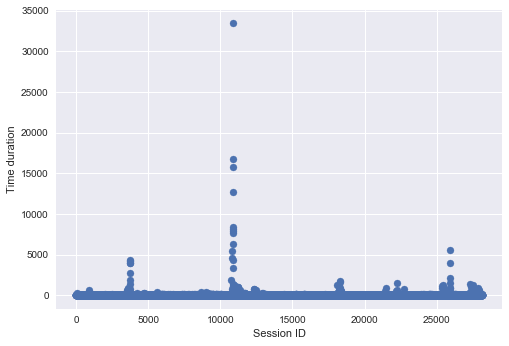

In [112]:
# Visualize the time duration of each session

# generate dataset
X = compressed_dataset['session.id']
y = compressed_dataset['session.duration']

# plot dataset
plt.scatter(X, y)

plt.xlabel("Session ID")
plt.ylabel("Time duration")
plt.show()

In [113]:
# Remove the outliers using Gaussian distribution
mean = np.mean(compressed_dataset['session.duration'], axis=0)
sd = np.std(compressed_dataset['session.duration'], axis=0)
compressed_dataset = compressed_dataset[compressed_dataset['session.duration'] > mean - 2 * sd]
compressed_dataset = compressed_dataset[compressed_dataset['session.duration'] < mean + 2 * sd]

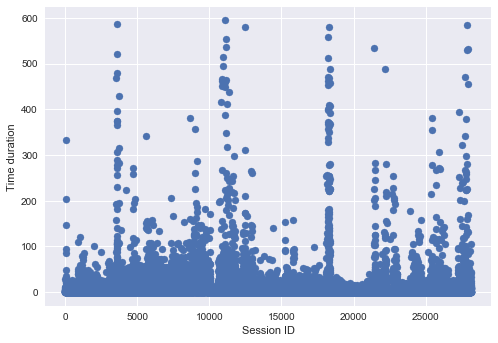

In [114]:
# Visualize the time duration of each session

# generate dataset
X = compressed_dataset['session.id']
y = compressed_dataset['session.duration']

# plot dataset
plt.scatter(X, y)

plt.xlabel("Session ID")
plt.ylabel("Time duration")
plt.show()

In [115]:
# Remove sessions that has zero time duration
compressed_dataset = compressed_dataset[compressed_dataset['session.duration'] != 0]
compressed_dataset = compressed_dataset.reset_index(drop=True)

In [148]:
output_filename = '../cleaned_data.csv'
compressed_dataset.to_csv(output_filename, header=True)

# 2. Data visualisation

In [149]:
input_filename = '../cleaned_data.csv'
clickdata_dataset = pd.read_csv(input_filename, encoding='utf-8', engine='python', index_col=0)

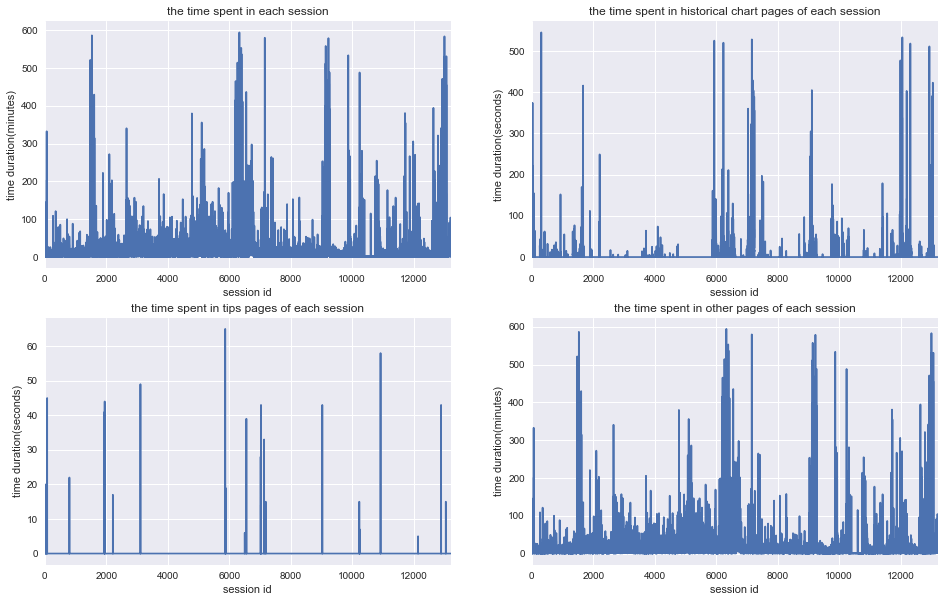

In [205]:
fig = plt.figure(figsize=(16, 10))

session = clickdata_dataset['session.duration']
hist = clickdata_dataset['hist.duration']
tips = clickdata_dataset['tips.duration']
others = clickdata_dataset['others.duration']

ax1 = fig.add_subplot(221)
ax1.set_xlabel('session id')
ax1.set_ylabel('time duration(minutes)')
ax1.set_title('the time spent in each session')
session.T.plot()

ax2 = fig.add_subplot(222)
ax2.set_xlabel('session id')
ax2.set_ylabel('time duration(seconds)')
ax2.set_title('the time spent in historical chart pages of each session')
hist.T.plot()

ax3 = fig.add_subplot(223)
ax3.set_xlabel('session id')
ax3.set_ylabel('time duration(seconds)')
ax3.set_title('the time spent in tips pages of each session')
tips.T.plot()

ax4 = fig.add_subplot(224)
ax4.set_xlabel('session id')
ax4.set_ylabel('time duration(minutes)')
ax4.set_title('the time spent in other pages of each session')
others.T.plot()

plt.show()

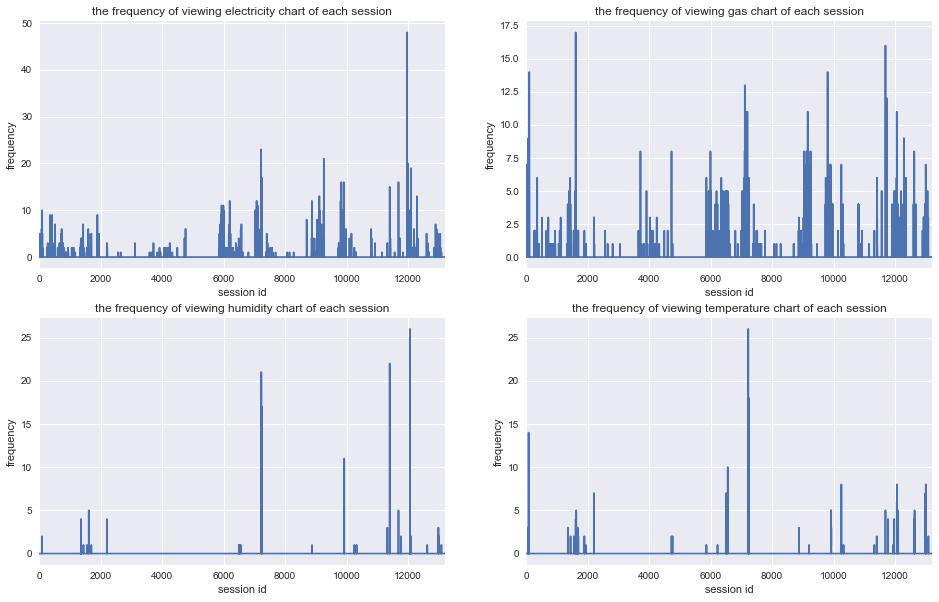

In [204]:
fig = plt.figure(figsize=(16, 10))

electricity = clickdata_dataset['hist.electricity']
gas = clickdata_dataset['hist.gas']
humidity = clickdata_dataset['hist.humidity']
temperature = clickdata_dataset['hist.temperature']

ax1 = fig.add_subplot(221)
ax1.set_xlabel('session id')
ax1.set_ylabel('frequency')
ax1.set_title('the frequency of viewing electricity chart of each session')
electricity.T.plot()

ax2 = fig.add_subplot(222)
ax2.set_xlabel('session id')
ax2.set_ylabel('frequency')
ax2.set_title('the frequency of viewing gas chart of each session')
gas.T.plot()

ax3 = fig.add_subplot(223)
ax3.set_xlabel('session id')
ax3.set_ylabel('frequency')
ax3.set_title('the frequency of viewing humidity chart of each session')
humidity.T.plot()

ax4 = fig.add_subplot(224)
ax4.set_xlabel('session id')
ax4.set_ylabel('frequency')
ax4.set_title('the frequency of viewing temperature chart of each session')
temperature.T.plot()

plt.show()

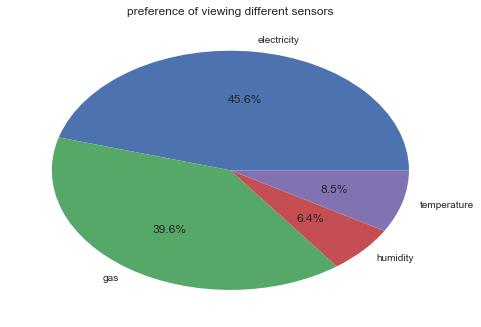

In [230]:
sensors = clickdata_dataset[['hist.electricity','hist.gas','hist.humidity','hist.temperature']]
sensors_sum = sensors.sum().to_frame()

plt.pie(sensors_sum,labels=['electricity','gas','humidity','temperature'],autopct='%1.1f%%')
plt.title('preference of viewing different sensors')
plt.show()

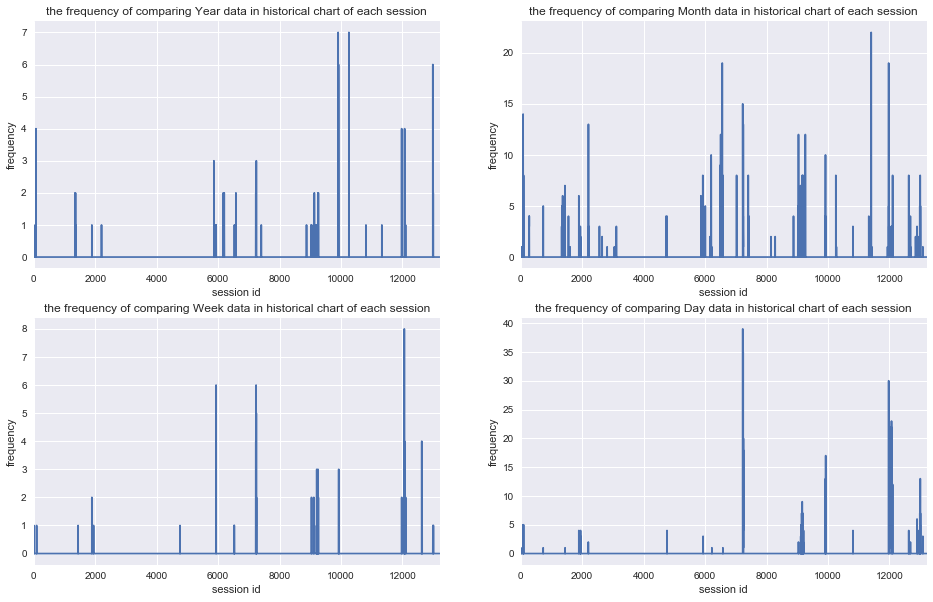

In [207]:
fig = plt.figure(figsize=(16, 10))

comparingYear = clickdata_dataset['hist.comparingYear']
comparingMonth = clickdata_dataset['hist.comparingMonth']
comparingWeek = clickdata_dataset['hist.comparingWeek']
comparingDay = clickdata_dataset['hist.comparingDay']

ax1 = fig.add_subplot(221)
ax1.set_xlabel('session id')
ax1.set_ylabel('frequency')
ax1.set_title('the frequency of comparing Year data in historical chart of each session')
comparingYear.T.plot()

ax2 = fig.add_subplot(222)
ax2.set_xlabel('session id')
ax2.set_ylabel('frequency')
ax2.set_title('the frequency of comparing Month data in historical chart of each session')
comparingMonth.T.plot()

ax3 = fig.add_subplot(223)
ax3.set_xlabel('session id')
ax3.set_ylabel('frequency')
ax3.set_title('the frequency of comparing Week data in historical chart of each session')
comparingWeek.T.plot()

ax4 = fig.add_subplot(224)
ax4.set_xlabel('session id')
ax4.set_ylabel('frequency')
ax4.set_title('the frequency of comparing Day data in historical chart of each session')
comparingDay.T.plot()

plt.show()

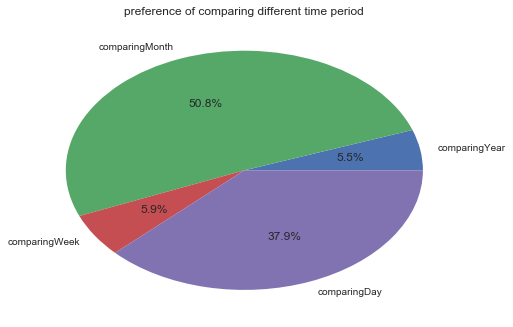

In [231]:
comparingYMWD = clickdata_dataset[['hist.comparingYear','hist.comparingMonth','hist.comparingWeek','hist.comparingDay']]
comparingYMWD_sum = comparingYMWD.sum().to_frame()

plt.pie(comparingYMWD_sum,labels=['comparingYear','comparingMonth','comparingWeek','comparingDay'],autopct='%1.1f%%')
plt.title('preference of comparing different time period')
plt.show()

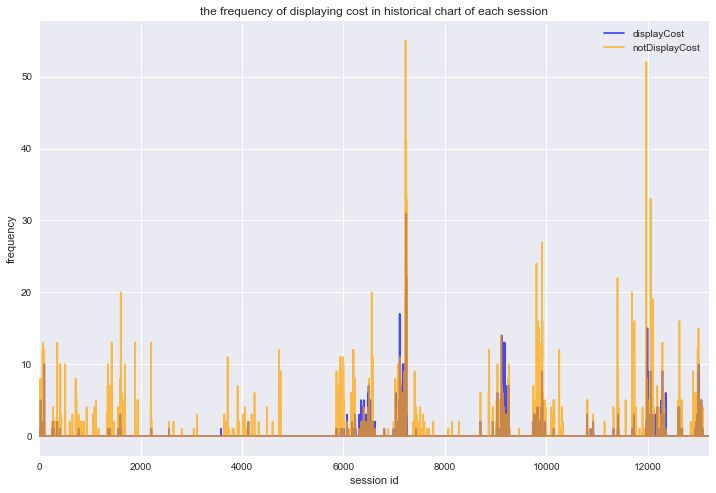

In [261]:
plt.figure(figsize=(12, 8))

hist_displayCost = clickdata_dataset['hist.displayCost']
hist_notDisplayCost = clickdata_dataset['hist.notDisplayCost']

hist_displayCost.T.plot(label='displayCost', alpha=0.7, color='blue')
hist_notDisplayCost.T.plot(label='notDisplayCost', alpha=0.7, color='orange')
plt.legend(loc='upper right')
plt.xlabel('session id')
plt.ylabel('frequency')
plt.title('the frequency of displaying cost in historical chart of each session')
plt.show()

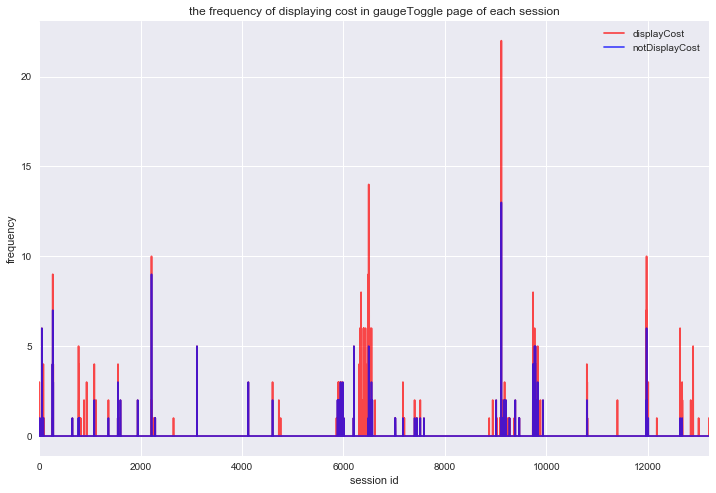

In [250]:
plt.figure(figsize=(12, 8))

hist_displayCost = clickdata_dataset['gaugeToggle.displayCost']
hist_notDisplayCost = clickdata_dataset['gaugeToggle.notDisplayCost']

hist_displayCost.T.plot(label='displayCost', alpha=0.7, color='red')
hist_notDisplayCost.T.plot(label='notDisplayCost', alpha=0.7, color='blue')
plt.legend(loc='upper right')
plt.xlabel('session id')
plt.ylabel('frequency')
plt.title('the frequency of displaying cost in gaugeToggle page of each session')
plt.show()

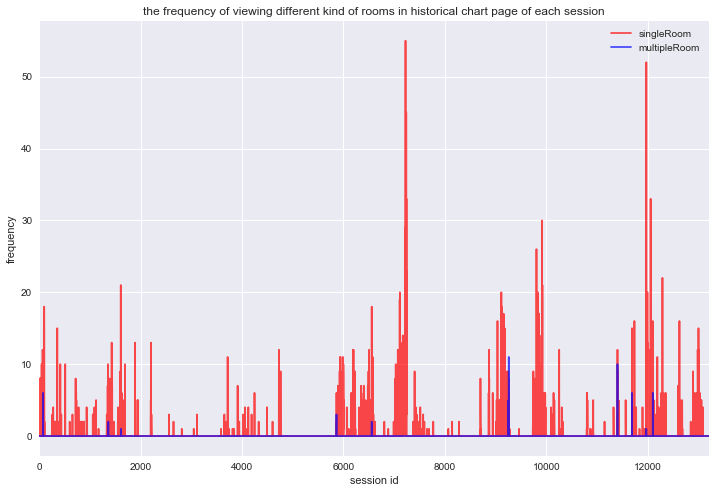

In [262]:
plt.figure(figsize=(12, 8))

hist_singleRoom = clickdata_dataset['hist.singleRoom']
hist_multipleRoom = clickdata_dataset['hist.multipleRoom']

hist_singleRoom.T.plot(label='singleRoom', alpha=0.7, color='red')
hist_multipleRoom.T.plot(label='multipleRoom', alpha=0.7, color='blue')
plt.legend(loc='upper right')
plt.xlabel('session id')
plt.ylabel('frequency')
plt.title('the frequency of viewing different kind of rooms in historical chart page of each session')
plt.show()

# 3. Seperate the dataset

In [8]:
input_filename = '../cleaned_data.csv'
release_filename = '../release_data.csv'

clickdata_dataset = pd.read_csv(input_filename, encoding='utf-8', engine='python', index_col=0)
release_dataset = pd.read_csv(release_filename, encoding='utf-8', engine='python', index_col=0)

release_dataset

,appuserid,homeid,WEEK_VIEW,MINUTE_VIEW,ENHANCED_VIEW,COMPARE_CHART,DUAL_CHART,HEATING_INTERVENTION
0,Heather,38,18/01/2017 12:04,18/01/2017 12:05,18/01/2017 12:00,29/05/2017 11:20,NaN,NaN
1,testIHD38,38,18/01/2017 12:04,18/01/2017 12:05,18/01/2017 12:00,29/05/2017 11:20,NaN,NaN
2,Aisling,47,15/03/2017 15:30,15/03/2017 15:30,07/04/2017 14:44,29/05/2017 11:18,NaN,NaN
3,Donalmacc,47,15/03/2017 15:30,15/03/2017 15:30,07/04/2017 14:44,29/05/2017 11:18,NaN,NaN
4,Martyn,55,15/05/2017 08:48,15/05/2017 08:48,15/05/2017 08:48,29/05/2017 11:18,NaN,NaN
5,Rebecca,55,15/05/2017 08:48,15/05/2017 08:48,15/05/2017 08:48,29/05/2017 11:18,NaN,NaN
6,Mingjun,56,29/05/2017 11:23,29/05/2017 11:23,29/05/2017 11:23,29/05/2017 11:23,NaN,NaN
7,temp12,56,29/05/2017 11:23,29/05/2017 11:23,29/05/2017 11:23,29/05/2017 11:23,NaN,NaN
8,FeIvgW4E1iBO159,59,15/03/2017 15:30,NaN,NaN,NaN,NaN,NaN
9,Scottwill,59,15/03/2017 15:30,NaN,NaN,NaN,NaN,NaN


# 4. Clustering

In [5]:
columns = [
       'session.duration',
       'hist.electricity',
       'hist.gas',
       'hist.displayCost',
       'hist.notDisplayCost',
       'hist.duration',
       'tips.count',
       'tips.duration',
       'gaugeToggle.displayCost',
       'gaugeToggle.notDisplayCost',
       'others.duration',
       'welcome.duration',
       # NOT acceessible features for all users
       'hist.temperature',
       'hist.humidity',
       'hist.comparingYear',
       'hist.comparingMonth',
       'hist.comparingWeek',
       'hist.comparingDay',
       'hist.singleRoom',
       'hist.multipleRoom',
       'view.display'
        ]

input_filename = '../cleaned_data.csv'
clickdata_dataset = pd.read_csv(input_filename, encoding='utf-8', usecols=columns[:12], engine='python')

In [123]:
# define the function to find the optimal clusters for k-means
def plot_optimal_kmeans_clusters(dataset, max_clusters):
    """Plot performance of different number of clusters.

    According to the plot, use 'elbow method' to find the optimal number of clusters.

    Args:
        dataset: The dataset is used for clustering.
        max_clusters: The max number of clusters used for searching.
    Returns:
        A plot shows the change of performance with the increse of cluster numbers.
    """
    # For each value of k calculate the sum of squared errors (SSE)
    K = range(1,max_clusters)
    KM = [KMeans(n_clusters=k).fit(dataset) for k in K]
    centroids = [k.cluster_centers_ for k in KM]

    D_k = [cdist(dataset, cent, 'euclidean') for cent in centroids]
    cIdx = [np.argmin(D,axis=1) for D in D_k]
    dist = [np.min(D,axis=1) for D in D_k]
    avgWithinSS = [sum(d)/dataset.shape[0] for d in dist]

    # Total with-in sum of square
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(dataset)**2)/dataset.shape[0]
    bss = tss-wcss

    kIdx = 2 # point where rate of decline changes the most

    # plot elbow curve
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    ax.plot(K[kIdx], avgWithinSS[kIdx], marker='o', markersize=12, 
    markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for KMeans clustering')
    plt.show()

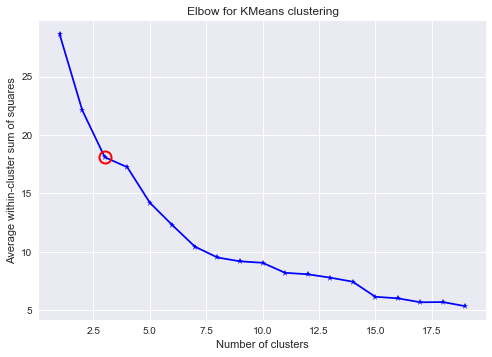

In [124]:
plot_optimal_kmeans_clusters(clickdata_dataset, 20)

In [153]:
def plot_optimal_transformation_method(transformation_methods, dataset, clusters, clustering_method):
    """Plot performance of different transformation methods.

    According to the plot, find the optimal transformation methods.

    Args:
        dataset: The dataset is used for clustering.
        clusters: The number of clusters used for clustering.
        transformation_methods: This is a list of methods.
        clustering_method: This can be K-means, GMM....
    Returns:
        A plot shows the change of clustering performance(silhouette_score, calinski_harabaz_score)
        using different transformation methods.
    """
    silhouette_scores = []
    calinski_harabaz_scores = []
    
    for transformation_method in transformation_methods:
        if transformation_method == 'None':
            transformed_dataset = dataset
        else:
            transformed_dataset = transformation_method().fit(dataset).transform(dataset)
            
        model = clustering_method(n_clusters=clusters).fit(transformed_dataset)
        labels = model.predict(transformed_dataset)
        silhouette_scores.append(silhouette_score(transformed_dataset, labels)) 
        calinski_harabaz_scores.append(calinski_harabaz_score(transformed_dataset, labels))
    
    # plot the figure
    x_ticks_labels = ['None', 'MinMaxScaler', 'Normalizer', 'RobustScaler', 'StandardScaler']
    
    fig = plt.figure(figsize=(10,8))
    ax1 = fig.add_subplot(211)   
    ax1.plot(np.arange(len(silhouette_scores)), silhouette_scores, color="green", linestyle='--', marker='o')
    ax1.set_xticks(np.arange(len(silhouette_scores)))
    ax1.set_xticklabels(x_ticks_labels, rotation='horizontal', fontsize=10)
    ax1.set_title('The silhouette_scores using different transformation methods')
    ax1.set_xlabel("Transformation methods")
    ax1.set_ylabel("silhouette_score")
    
    ax2 = fig.add_subplot(212)   
    ax2.plot(np.arange(len(calinski_harabaz_scores)), calinski_harabaz_scores, color="red", linestyle='--', marker='o')
    ax2.set_xticks(np.arange(len(calinski_harabaz_scores)))
    ax2.set_xticklabels(x_ticks_labels, rotation='horizontal', fontsize=10)
    ax2.set_title('The calinski_harabaz_scores using different transformation methods')
    ax2.set_xlabel("Transformation methods")
    ax2.set_ylabel("calinski_harabaz_score")
    plt.tight_layout()
    plt.show()

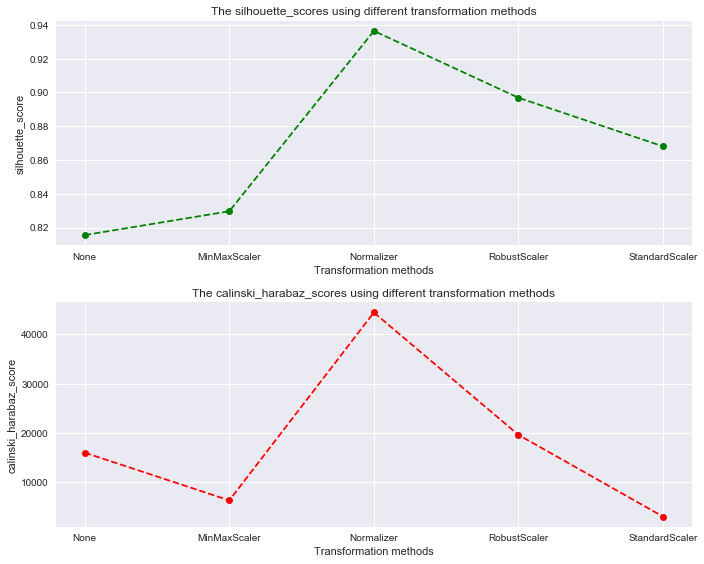

In [154]:
transformation_methods = ['None', MinMaxScaler, Normalizer, RobustScaler, StandardScaler]
plot_optimal_transformation_method(transformation_methods, clickdata_dataset, 3, KMeans)

In [229]:
def plot_optimal_feature_dimensions(clusters):
    """Plot performance of using different dimensions for clustering.

    According to the plot, find the optimal dimensions.

    Args:
        clusters: The optimal number of clusters.
    Returns:
        A plot shows the change of clustering performance(silhouette_score, calinski_harabaz_score)
        using different dimensions by different clustering methods.
    """
    input_filename = '../cleaned_data.csv'
    silhouette_scores_KM = []
    calinski_harabaz_scores_KM = []
    silhouette_scores_GMM = []
    calinski_harabaz_scores_GMM = []
    silhouette_scores_HC = []
    calinski_harabaz_scores_HC = []

    for i in range(2,22):   
        # read the dataset using i dimensions
        dataset = pd.read_csv(input_filename, encoding='utf-8', usecols=columns[:i], engine='python')
        transformed_dataset = Normalizer().fit(dataset).transform(dataset)
        
        
        # calculate metrics for different clustering algorithms
        # Hierarchical clustering
        data_dist = pdist(transformed_dataset,'euclidean') # computing the euclidean distance
        data_link = linkage(data_dist, method='ward') # computing the linkage
        labels_HC = fcluster(data_link, t=15, criterion='distance')
        silhouette_scores_HC.append(silhouette_score(transformed_dataset, labels_HC)) 
        calinski_harabaz_scores_HC.append(calinski_harabaz_score(transformed_dataset, labels_HC))
        
        # K-means clustering
        KM = KMeans(n_clusters=clusters).fit(transformed_dataset)
        labels_KM = KM.predict(transformed_dataset)
        silhouette_scores_KM.append(silhouette_score(transformed_dataset, labels_KM)) 
        calinski_harabaz_scores_KM.append(calinski_harabaz_score(transformed_dataset, labels_KM))
        
        # Gaussian mixture model
        GMM = GaussianMixture(n_components=clusters).fit(transformed_dataset)
        labels_GMM = GMM.predict(transformed_dataset)
        silhouette_scores_GMM.append(silhouette_score(transformed_dataset, labels_GMM)) 
        calinski_harabaz_scores_GMM.append(calinski_harabaz_score(transformed_dataset, labels_GMM))

    # plot the figure
    fig = plt.figure(figsize=(10,8))
    ax1 = fig.add_subplot(211)   
    ax1.plot(np.arange(2,22), silhouette_scores_HC, color="green", linestyle='--', marker='o')
    ax1.plot(np.arange(2,22), silhouette_scores_KM, color="blue", linestyle='--', marker='o')
    ax1.plot(np.arange(2,22), silhouette_scores_GMM, color="red", linestyle='--', marker='o')
    ax1.set_title('The silhouette_scores using different dimensions by different clustering algorithms')
    ax1.set_xlabel("The number of dimensions")
    ax1.set_ylabel("silhouette_score")
    ax1.legend(["Hierarchical clustering", "K-means clustering", "Gaussian mixture model"], loc="best")

    ax2 = fig.add_subplot(212)   
    ax2.plot(np.arange(2,22), calinski_harabaz_scores_HC, color="green", linestyle='--', marker='o')
    ax2.plot(np.arange(2,22), calinski_harabaz_scores_KM, color="blue", linestyle='--', marker='o')
    ax2.plot(np.arange(2,22), calinski_harabaz_scores_GMM, color="red", linestyle='--', marker='o')
    ax2.set_title('The calinski_harabaz_scores using different dimensions by different clustering algorithms')
    ax2.set_xlabel("The number of dimensions")
    ax2.set_ylabel("calinski_harabaz_score")
    ax2.legend(["Hierarchical clustering", "K-means clustering", "Gaussian mixture model"], loc="best")
    
    plt.tight_layout()
    plt.show()

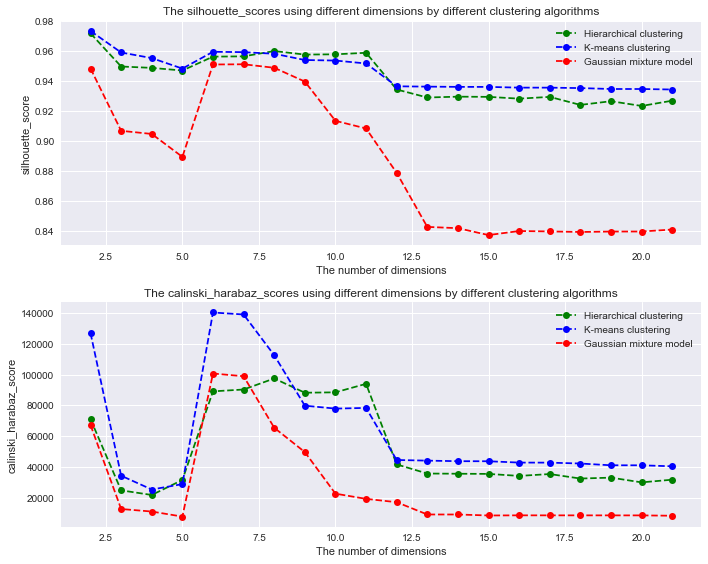

In [230]:
plot_optimal_feature_dimensions(clusters=3)

In [8]:
def calculate_evolution(clusters):
    """Calculate the labels that different clustering algorithms run on the different dimensions.

    Simply choose 3 dimensions, that are 1 dimension, 12 dimensions and all the dimensions(21).
    The first 1 dimension is the session.duration, I just want to use this as a baseline.
    The first 12 dimensions are the dimensions that are available for all users.
    The whole dimensions are the dimensions we can use in the dataset.

    Args:
        clusters: The optimal number of clusters.
    Returns:
        Three lists of labels, which records the clustering results.
    """
    input_filename = '../cleaned_data.csv'
    dimensions = [1,11,12,21]
    labels_HC = []
    labels_KM = []
    labels_GMM = []
    
    for i in dimensions:   
        # read the dataset using i dimensions
        if i == 11:
            dataset = pd.read_csv(input_filename, encoding='utf-8', usecols=columns[1:i], engine='python')
        else:
            dataset = pd.read_csv(input_filename, encoding='utf-8', usecols=columns[:i], engine='python')
        
        if i == 1:
            transformed_dataset = dataset
        else:
            transformed_dataset = Normalizer().fit(dataset).transform(dataset)
    
        # calculate metrics for different clustering algorithms
        # Hierarchical clustering
        data_dist = pdist(transformed_dataset,'euclidean') # computing the euclidean distance
        data_link = linkage(data_dist, method='ward') # computing the linkage
        label_HC = fcluster(data_link, t=clusters, criterion='maxclust')
        labels_HC.append(label_HC)
        
        # K-means clustering
        KM = KMeans(n_clusters=clusters).fit(transformed_dataset)
        label_KM = KM.predict(transformed_dataset)
        labels_KM.append(label_KM)
        
        # Gaussian mixture model
        GMM = GaussianMixture(n_components=clusters).fit(transformed_dataset)
        label_GMM = GMM.predict(transformed_dataset)
        labels_GMM.append(label_GMM)
    
    return (labels_HC, labels_KM, labels_GMM)

def plot_evolution(labels_HC, labels_KM, labels_GMM):
    """Visualize the evolution of clusters changed with the increase of dimensions.

    Simply choose 3 dimensions, that are 1 dimension, 12 dimensions and all the dimensions(21).
    The first 1 dimension is the session.duration, I just want to use this as a baseline.
    The first 12 dimensions are the dimensions that are available for all users.
    The whole dimensions are the dimensions we can use in the dataset.

    Args:
        labels_HC: The labels got from Hierarchical clustering
        labels_KM: The labels got from K-means clustering
        labels_GMM: The labels got from Gaussian mixture model
    Returns:
        A plot shows evolution of clusters changed, based on this, we can know what is the difference using different
        algorithms and different dimensions.
    """
    input_filename = '../cleaned_data.csv'
    dimensions = [1,1,1,11,11,11,12,12,12,21,21,21]
    
    clickdata_dataset = pd.read_csv(input_filename, encoding='utf-8', engine='python')

    fig, axes = plt.subplots(4, 3, figsize=(20, 10))
    ax = axes.ravel()

    for i,j in zip(range(12), dimensions):
        if i == 0 or i == 3 or i == 6 or i == 9:
            label = pd.DataFrame(data=labels_HC[int(i/3)],columns=['label'])
            labeled_clickdata_dataset = pd.concat([clickdata_dataset, label],axis=1)
            cluster_0 = labeled_clickdata_dataset[labeled_clickdata_dataset['label'] == 1]
            cluster_1 = labeled_clickdata_dataset[labeled_clickdata_dataset['label'] == 2]
            cluster_2 = labeled_clickdata_dataset[labeled_clickdata_dataset['label'] == 3]
            c0 = ax[i].scatter(cluster_0['session.id'],cluster_0['session.duration'],c='r',marker='+')
            c1 = ax[i].scatter(cluster_1['session.id'],cluster_1['session.duration'],c='g',marker='o')
            c2 = ax[i].scatter(cluster_2['session.id'],cluster_2['session.duration'],c='b',marker='*')
            ax[i].legend([c0, c1, c2], ['cluster1', 'cluster2','cluster3'])
            ax[i].set_title('Hierarchical clustering using %d dimensions' % j)
            ax[i].set_xlabel("Session ID")
            ax[i].set_ylabel("Session duration")
        elif i == 1 or i == 4 or i == 7 or i == 10:
            label = pd.DataFrame(data=labels_KM[int((i-1)/3)],columns=['label'])
            labeled_clickdata_dataset = pd.concat([clickdata_dataset, label],axis=1)
            cluster_0 = labeled_clickdata_dataset[labeled_clickdata_dataset['label'] == 0]
            cluster_1 = labeled_clickdata_dataset[labeled_clickdata_dataset['label'] == 1]
            cluster_2 = labeled_clickdata_dataset[labeled_clickdata_dataset['label'] == 2]
            c0 = ax[i].scatter(cluster_0['session.id'],cluster_0['session.duration'],c='r',marker='+')
            c1 = ax[i].scatter(cluster_1['session.id'],cluster_1['session.duration'],c='g',marker='o')
            c2 = ax[i].scatter(cluster_2['session.id'],cluster_2['session.duration'],c='b',marker='*')
            ax[i].legend([c0, c1, c2], ['cluster1', 'cluster2','cluster3'])
            ax[i].set_title('K-means clustering using %d dimensions' % j)
            ax[i].set_xlabel("Session ID")
            ax[i].set_ylabel("Session duration")
        else:
            label = pd.DataFrame(data=labels_GMM[int((i-2)/3)],columns=['label'])
            labeled_clickdata_dataset = pd.concat([clickdata_dataset, label],axis=1)
            cluster_0 = labeled_clickdata_dataset[labeled_clickdata_dataset['label'] == 0]
            cluster_1 = labeled_clickdata_dataset[labeled_clickdata_dataset['label'] == 1]
            cluster_2 = labeled_clickdata_dataset[labeled_clickdata_dataset['label'] == 2]
            c0 = ax[i].scatter(cluster_0['session.id'],cluster_0['session.duration'],c='r',marker='+')
            c1 = ax[i].scatter(cluster_1['session.id'],cluster_1['session.duration'],c='g',marker='o')
            c2 = ax[i].scatter(cluster_2['session.id'],cluster_2['session.duration'],c='b',marker='*')
            ax[i].legend([c0, c1, c2], ['cluster1', 'cluster2','cluster3'])
            ax[i].set_title('Gaussian mixture model clustering using %d dimensions' % j)
            ax[i].set_xlabel("Session ID")
            ax[i].set_ylabel("Session duration")
    fig.tight_layout()        
    plt.show()
    

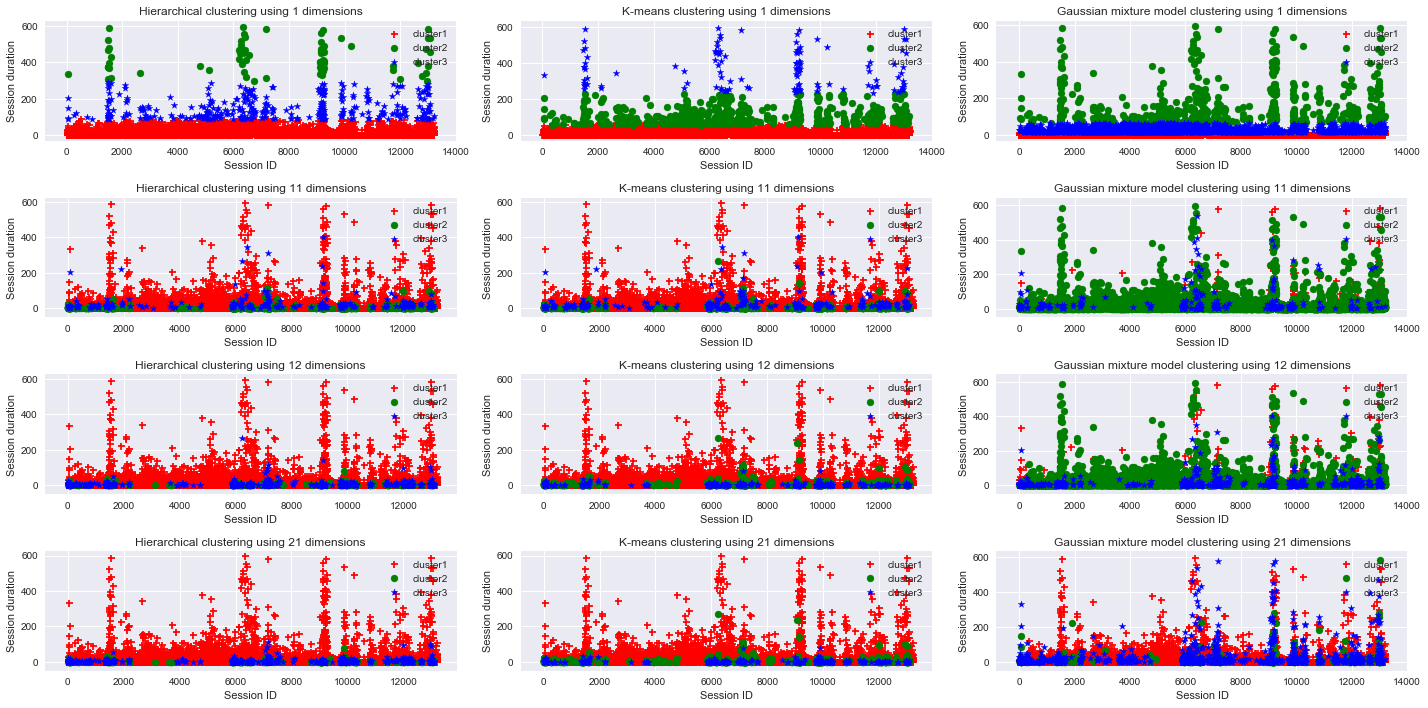

In [9]:
labels_HC, labels_KM, labels_GMM = calculate_evolution(3)
plot_evolution(labels_HC, labels_KM, labels_GMM)

In [ ]:
# plot the figure
    cluster_0 = labeled_clickdata_dataset[labeled_clickdata_dataset['label'] == 0]
    cluster_1 = labeled_clickdata_dataset[labeled_clickdata_dataset['label'] == 1]
    cluster_2 = labeled_clickdata_dataset[labeled_clickdata_dataset['label'] == 2]

   
    c0 = plt.scatter(cluster_0['session.id'],cluster_0['session.duration'],c='r',marker='+')
    c1 = plt.scatter(cluster_1['session.id'],cluster_1['session.duration'],c='g',marker='o')
    c2 = plt.scatter(cluster_2['session.id'],cluster_2['session.duration'],c='b',marker='*')
    plt.legend([c0, c1, c2], ['cluster0', 'cluster1','cluster2'])
    plt.show()

In [67]:
dataset_Normalizer = Normalizer().fit(clickdata_dataset).transform(clickdata_dataset)
KM = KMeans(n_clusters=3).fit(dataset_Normalizer)
labels = KM.predict(dataset_Normalizer)
print('silhouette score of K-means clustering:', silhouette_score(dataset_Normalizer, labels))
print('calinski harabaz score of K-means clustering:', calinski_harabaz_score(dataset_Normalizer, labels))

silhouette score of K-means clustering: 0.936381036789
calinski harabaz score of K-means clustering: 44453.323012


In [69]:
input_filename = '../cleaned_data.csv'
clickdata_dataset = pd.read_csv(input_filename, encoding='utf-8', engine='python')
label = pd.DataFrame(data=labels,columns=['label'])
labeled_clickdata_dataset = pd.concat([clickdata_dataset, label],axis=1)

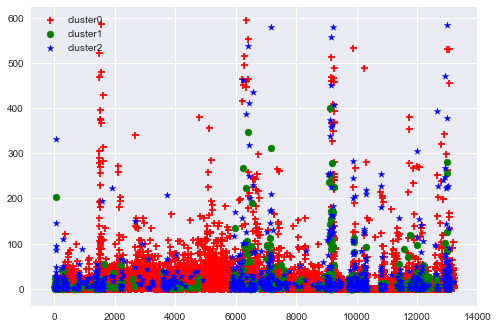

In [106]:
# GMM
cluster_0 = labeled_clickdata_dataset[labeled_clickdata_dataset['label'] == 0]
cluster_1 = labeled_clickdata_dataset[labeled_clickdata_dataset['label'] == 1]
cluster_2 = labeled_clickdata_dataset[labeled_clickdata_dataset['label'] == 2]

plt.figure()
c0 = plt.scatter(cluster_0['session.id'],cluster_0['session.duration'],c='r',marker='+')
c1 = plt.scatter(cluster_1['session.id'],cluster_1['session.duration'],c='g',marker='o')
c2 = plt.scatter(cluster_2['session.id'],cluster_2['session.duration'],c='b',marker='*')
plt.legend([c0, c1, c2], ['cluster0', 'cluster1','cluster2'])
plt.show()

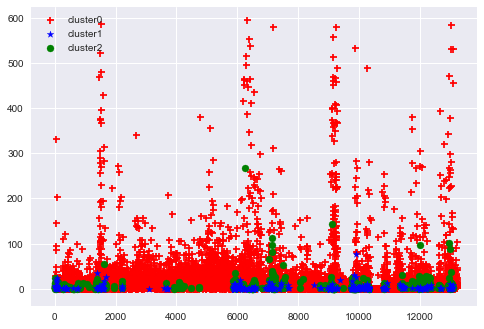

In [88]:
# HC
cluster_0 = labeled_clickdata_dataset[labeled_clickdata_dataset['label'] == 1]
cluster_1 = labeled_clickdata_dataset[labeled_clickdata_dataset['label'] == 2]
cluster_2 = labeled_clickdata_dataset[labeled_clickdata_dataset['label'] == 3]

plt.figure()
c0 = plt.scatter(cluster_0['session.id'],cluster_0['session.duration'],c='r',marker='+')
c2 = plt.scatter(cluster_2['session.id'],cluster_2['session.duration'],c='g',marker='o')
c1 = plt.scatter(cluster_1['session.id'],cluster_1['session.duration'],c='b',marker='*')
plt.legend([c0, c1, c2], ['cluster0', 'cluster1','cluster2'])
plt.show()

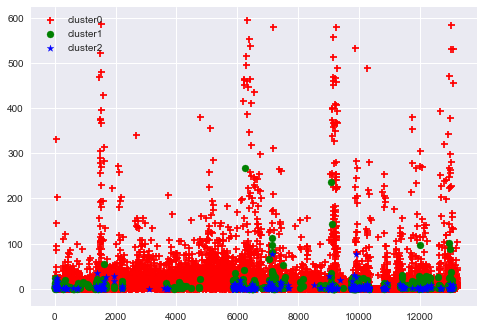

In [70]:
# KMeans
cluster_0 = labeled_clickdata_dataset[labeled_clickdata_dataset['label'] == 0]
cluster_1 = labeled_clickdata_dataset[labeled_clickdata_dataset['label'] == 1]
cluster_2 = labeled_clickdata_dataset[labeled_clickdata_dataset['label'] == 2]

plt.figure()
c0 = plt.scatter(cluster_0['session.id'],cluster_0['session.duration'],c='r',marker='+')
c1 = plt.scatter(cluster_1['session.id'],cluster_1['session.duration'],c='g',marker='o')
c2 = plt.scatter(cluster_2['session.id'],cluster_2['session.duration'],c='b',marker='*')
plt.legend([c0, c1, c2], ['cluster0', 'cluster1','cluster2'])
plt.show()

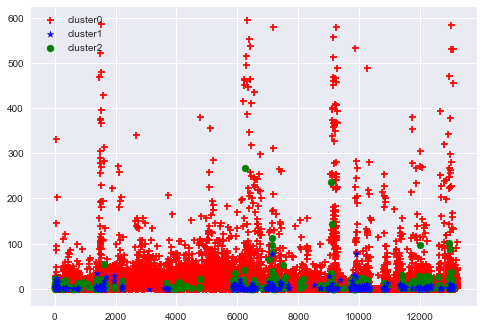

In [77]:
cluster_0 = labeled_clickdata_dataset[labeled_clickdata_dataset['label'] == 0]
cluster_1 = labeled_clickdata_dataset[labeled_clickdata_dataset['label'] == 1]
cluster_2 = labeled_clickdata_dataset[labeled_clickdata_dataset['label'] == 2]

plt.figure()
c0 = plt.scatter(cluster_0['session.id'],cluster_0['session.duration'],c='r',marker='+')
c2 = plt.scatter(cluster_2['session.id'],cluster_2['session.duration'],c='g',marker='o')
c1 = plt.scatter(cluster_1['session.id'],cluster_1['session.duration'],c='b',marker='*')
plt.legend([c0, c1, c2], ['cluster0', 'cluster1','cluster2'])
plt.show()

In [71]:
columns = [
       #'session.id',
       'session.duration',
       #'guiAccess.homeid', 
       #'guiAccess.userid', 
       #'guiAccess.timestamp.start',
       #'guiAccess.timestamp.end',
       'hist.electricity',
       'hist.gas',
       'hist.temperature',
       #'hist.humidity',
       'hist.displayCost',
       'hist.notDisplayCost',
       #'hist.comparingYear',
       #'hist.comparingMonth',
       #'hist.comparingWeek',
       #'hist.comparingDay',
       #'hist.singleRoom',
       #'hist.multipleRoom',
       'hist.duration',
       'tips.count',
       'tips.duration',
       'gaugeToggle.displayCost',
       'gaugeToggle.notDisplayCost',
       #'view.display',
       'others.duration',
       'welcome.duration'
        ]

input_filename = '../cleaned_data.csv'
clickdata_dataset = pd.read_csv(input_filename, encoding='utf-8', usecols=columns, engine='python')

In [72]:
dataset_Normalizer = Normalizer().fit(clickdata_dataset).transform(clickdata_dataset)
KM = KMeans(n_clusters=3).fit(dataset_Normalizer)
labels = KM.predict(dataset_Normalizer)
print('silhouette score of K-means clustering:', silhouette_score(dataset_Normalizer, labels))
print('calinski harabaz score of K-means clustering:', calinski_harabaz_score(dataset_Normalizer, labels))

silhouette score of K-means clustering: 0.936165985154
calinski harabaz score of K-means clustering: 44027.9249265


In [73]:
input_filename = '../cleaned_data.csv'
clickdata_dataset = pd.read_csv(input_filename, encoding='utf-8', engine='python')
label = pd.DataFrame(data=labels,columns=['label'])
labeled_clickdata_dataset = pd.concat([clickdata_dataset, label],axis=1)

In [57]:
duration_dataset = clickdata_dataset['session.duration'].to_frame()

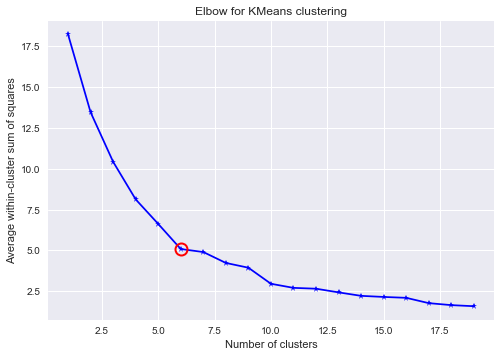

In [18]:
# K-means clustering 

# find the optimal cluster number k using 'elbow method'
K = range(1,20)
KM = [KMeans(n_clusters=k).fit(duration_dataset) for k in K]
centroids = [k.cluster_centers_ for k in KM]

D_k = [cdist(duration_dataset, cent, 'euclidean') for cent in centroids]
cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/duration_dataset.shape[0] for d in dist]

# Total with-in sum of square
wcss = [sum(d**2) for d in dist]
tss = sum(pdist(duration_dataset)**2)/duration_dataset.shape[0]
bss = tss-wcss

kIdx = 5 # point where rate of decline changes the most, so actually the number of clusters should be 3

# elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, avgWithinSS, 'b*-')
ax.plot(K[kIdx], avgWithinSS[kIdx], marker='o', markersize=12, 
markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow for KMeans clustering')
plt.show()

In [58]:
KM = KMeans(n_clusters=3).fit(duration_dataset)
labels = KM.predict(duration_dataset)
print('silhouette score of K-means clustering:', silhouette_score(duration_dataset, labels))
print('calinski harabaz score of K-means clustering:', calinski_harabaz_score(duration_dataset, labels))

silhouette score of K-means clustering: 0.84297524298
calinski harabaz score of K-means clustering: 31511.1571209


In [59]:
label = pd.DataFrame(data=labels,columns=['label'])
labeled_clickdata_dataset = pd.concat([clickdata_dataset, label],axis=1)

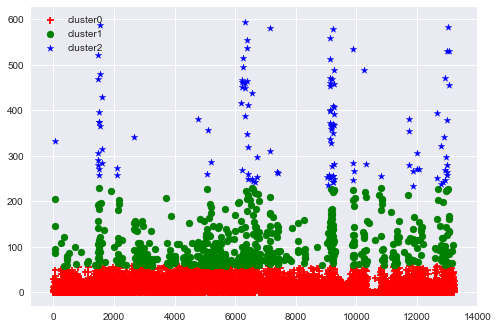

In [60]:
cluster_0 = labeled_clickdata_dataset[labeled_clickdata_dataset['label'] == 0]
cluster_1 = labeled_clickdata_dataset[labeled_clickdata_dataset['label'] == 1]
cluster_2 = labeled_clickdata_dataset[labeled_clickdata_dataset['label'] == 2]

plt.figure()
c0 = plt.scatter(cluster_0['session.id'],cluster_0['session.duration'],c='r',marker='+')
c1 = plt.scatter(cluster_1['session.id'],cluster_1['session.duration'],c='g',marker='o')
c2 = plt.scatter(cluster_2['session.id'],cluster_2['session.duration'],c='b',marker='*')
plt.legend([c0, c1, c2], ['cluster0', 'cluster1','cluster2'])
plt.show()

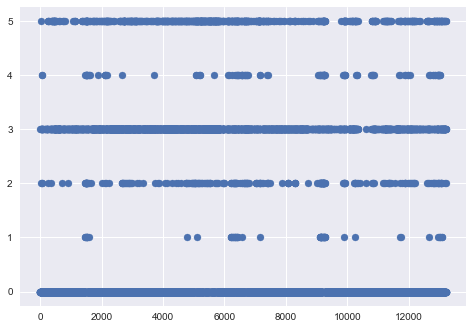

In [38]:
X = clickdata_dataset['session.id']
plt.figure()
plt.scatter(X, labels)
plt.show()

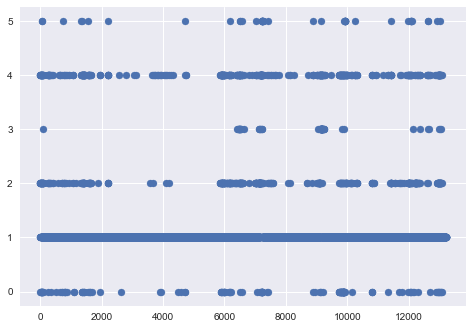

In [42]:
X = clickdata_dataset['session.id']
plt.figure()
plt.scatter(X, labels)
plt.show()

In [25]:
dataset = clickdata_dataset.drop(['guiAccess.timestamp.start','guiAccess.timestamp.end','session.id','guiAccess.userid','guiAccess.homeid'], 1)

# keep the first two principal components of the data
pca = PCA(n_components=3)
# fit PCA model to beast cancer data
pca.fit(dataset)

# transform data onto the first two principal components
dataset_pca = pca.transform(dataset)
print("Original shape: {}".format(str(dataset.shape)))
print("Reduced shape: {}".format(str(dataset_pca.shape)))

Original shape: (13210, 21)
Reduced shape: (13210, 3)


In [26]:
dataset_pca

array([[-23.57703491,   3.89855775,   1.73623733],
       [ 15.14212699,  -3.7092511 ,   1.00390194],
       [-19.77582694,  11.97881825,   1.32370742],
       ..., 
       [-15.93703086,  -2.67954443,  -0.91535852],
       [  8.67596535,  -3.61373337,  -0.98153309],
       [ -4.45730448,  -2.67900416,   5.03598552]])

In [22]:
dataset_Normalizer  = Normalizer().fit(dataset_pca).transform(dataset_pca)

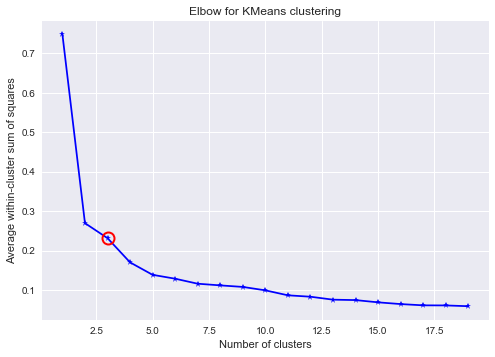

In [23]:
# K-means clustering 

# find the optimal cluster number k using 'elbow method'
K = range(1,20)
KM = [KMeans(n_clusters=k).fit(dataset_Normalizer) for k in K]
centroids = [k.cluster_centers_ for k in KM]

D_k = [cdist(dataset_Normalizer, cent, 'euclidean') for cent in centroids]
cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/dataset_Normalizer.shape[0] for d in dist]

# Total with-in sum of square
wcss = [sum(d**2) for d in dist]
tss = sum(pdist(dataset_Normalizer)**2)/dataset_Normalizer.shape[0]
bss = tss-wcss

kIdx = 2 # point where rate of decline changes the most, so actually the number of clusters should be 3

# elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, avgWithinSS, 'b*-')
ax.plot(K[kIdx], avgWithinSS[kIdx], marker='o', markersize=12, 
markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow for KMeans clustering')
plt.show()

In [ ]:
KM = KMeans(n_clusters=6).fit(duration_dataset)
labels = KM.predict(duration_dataset)
print('silhouette score of K-means clustering:', silhouette_score(duration_dataset, labels))
print('calinski harabaz score of K-means clustering:', calinski_harabaz_score(duration_dataset, labels))

## 3.1 K-means clustering

### 3.1.1 K-means using all the dimensions

In [43]:
dataset = clickdata_dataset.drop(['guiAccess.timestamp.start','guiAccess.timestamp.end','session.id','guiAccess.userid','guiAccess.homeid'], 1)

In [44]:
# 1. For well-defined data, should not scale the data.
#    K-means might be a bad choice since you need something that can handle naturally
# 2. For mixed numerical data, should scale the data. Using StandardScaler/RobustScaler/MinMaxScaler/Normalizer
# 3. For binary values, k-means clustering is a bad choice. 
#    K-means needs to compute means, and the mean value is not meaningful on this kind of data.

dataset_MinMaxScaler   = MinMaxScaler().fit(dataset).transform(dataset)
dataset_Normalizer     = Normalizer().fit(dataset).transform(dataset)
dataset_RobustScaler   = RobustScaler().fit(dataset).transform(dataset)
dataset_StandardScaler = StandardScaler().fit(dataset).transform(dataset)

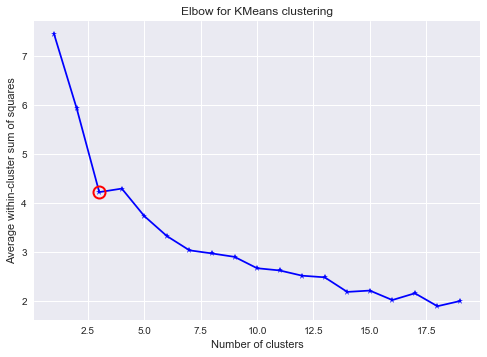

In [45]:
# K-means clustering 

# find the optimal cluster number k using 'elbow method'
K = range(1,20)
KM = [KMeans(n_clusters=k).fit(dataset_RobustScaler) for k in K]
centroids = [k.cluster_centers_ for k in KM]

D_k = [cdist(dataset_RobustScaler, cent, 'euclidean') for cent in centroids]
cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/dataset_RobustScaler.shape[0] for d in dist]

# Total with-in sum of square
wcss = [sum(d**2) for d in dist]
tss = sum(pdist(dataset_RobustScaler)**2)/dataset_RobustScaler.shape[0]
bss = tss-wcss

kIdx = 2 # point where rate of decline changes the most, so actually the number of clusters should be 3

# elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, avgWithinSS, 'b*-')
ax.plot(K[kIdx], avgWithinSS[kIdx], marker='o', markersize=12, 
markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow for KMeans clustering')
plt.show()

In [46]:
# Compare different data transformation methods
KM = KMeans(n_clusters=3).fit(dataset)
labels = KM.predict(dataset)
print('Without data transformation')
print('silhouette score of K-means clustering:', silhouette_score(dataset, labels))
print('calinski harabaz score of K-means clustering:', calinski_harabaz_score(dataset, labels))

KM = KMeans(n_clusters=3).fit(dataset_StandardScaler)
labels = KM.predict(dataset_StandardScaler)
print('StandardScaler')
print('silhouette score of K-means clustering:', silhouette_score(dataset_StandardScaler, labels))
print('calinski harabaz score of K-means clustering:', calinski_harabaz_score(dataset_StandardScaler, labels))

KM = KMeans(n_clusters=3).fit(dataset_RobustScaler)
labels = KM.predict(dataset_RobustScaler)
print('RobustScaler')
print('silhouette score of K-means clustering:', silhouette_score(dataset_RobustScaler, labels))
print('calinski harabaz score of K-means clustering:', calinski_harabaz_score(dataset_RobustScaler, labels))

KM = KMeans(n_clusters=3).fit(dataset_MinMaxScaler)
labels = KM.predict(dataset_MinMaxScaler)
print('MinMaxScaler')
print('silhouette score of K-means clustering:', silhouette_score(dataset_MinMaxScaler, labels))
print('calinski harabaz score of K-means clustering:', calinski_harabaz_score(dataset_MinMaxScaler, labels))

KM = KMeans(n_clusters=3).fit(dataset_Normalizer)
labels = KM.predict(dataset_Normalizer)
print('Normalizer')
print('silhouette score of K-means clustering:', silhouette_score(dataset_Normalizer, labels))
print('calinski harabaz score of K-means clustering:', calinski_harabaz_score(dataset_Normalizer, labels))

Without data transformation
silhouette score of K-means clustering: 0.814920079531
calinski harabaz score of K-means clustering: 15955.4586058
StandardScaler
silhouette score of K-means clustering: 0.872666146612
calinski harabaz score of K-means clustering: 2457.08815625
RobustScaler
silhouette score of K-means clustering: 0.895576809853
calinski harabaz score of K-means clustering: 19155.6003256
MinMaxScaler
silhouette score of K-means clustering: 0.851552198557
calinski harabaz score of K-means clustering: 4861.1678715
Normalizer
silhouette score of K-means clustering: 0.934249839328
calinski harabaz score of K-means clustering: 40344.6086909


In [51]:
label = pd.DataFrame(data=labels,columns=['label'])
#dataset = clickdata_dataset.drop(['guiAccess.timestamp.start','guiAccess.timestamp.end','guiAccess.userid','guiAccess.homeid'], 1)
labeled_clickdata_dataset = pd.concat([clickdata_dataset, label],axis=1)

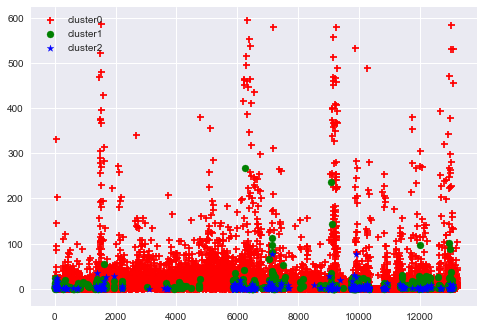

In [53]:
cluster_0 = labeled_clickdata_dataset[labeled_clickdata_dataset['label'] == 0]
cluster_1 = labeled_clickdata_dataset[labeled_clickdata_dataset['label'] == 1]
cluster_2 = labeled_clickdata_dataset[labeled_clickdata_dataset['label'] == 2]

plt.figure()
c0 = plt.scatter(cluster_0['session.id'],cluster_0['session.duration'],c='r',marker='+')
c1 = plt.scatter(cluster_1['session.id'],cluster_1['session.duration'],c='g',marker='o')
c2 = plt.scatter(cluster_2['session.id'],cluster_2['session.duration'],c='b',marker='*')
plt.legend([c0, c1, c2], ['cluster0', 'cluster1','cluster2'])
plt.show()

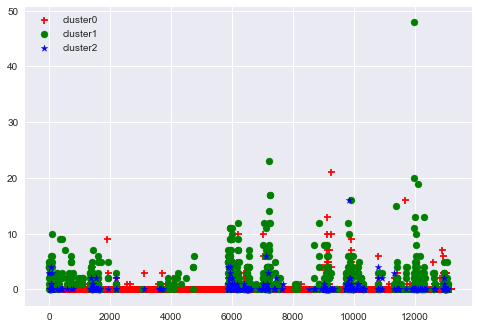

In [54]:
cluster_0 = labeled_clickdata_dataset[labeled_clickdata_dataset['label'] == 0]
cluster_1 = labeled_clickdata_dataset[labeled_clickdata_dataset['label'] == 1]
cluster_2 = labeled_clickdata_dataset[labeled_clickdata_dataset['label'] == 2]

plt.figure()
c0 = plt.scatter(cluster_0['session.id'],cluster_0['hist.electricity'],c='r',marker='+')
c1 = plt.scatter(cluster_1['session.id'],cluster_1['hist.electricity'],c='g',marker='o')
c2 = plt.scatter(cluster_2['session.id'],cluster_2['hist.electricity'],c='b',marker='*')
plt.legend([c0, c1, c2], ['cluster0', 'cluster1','cluster2'])
plt.show()

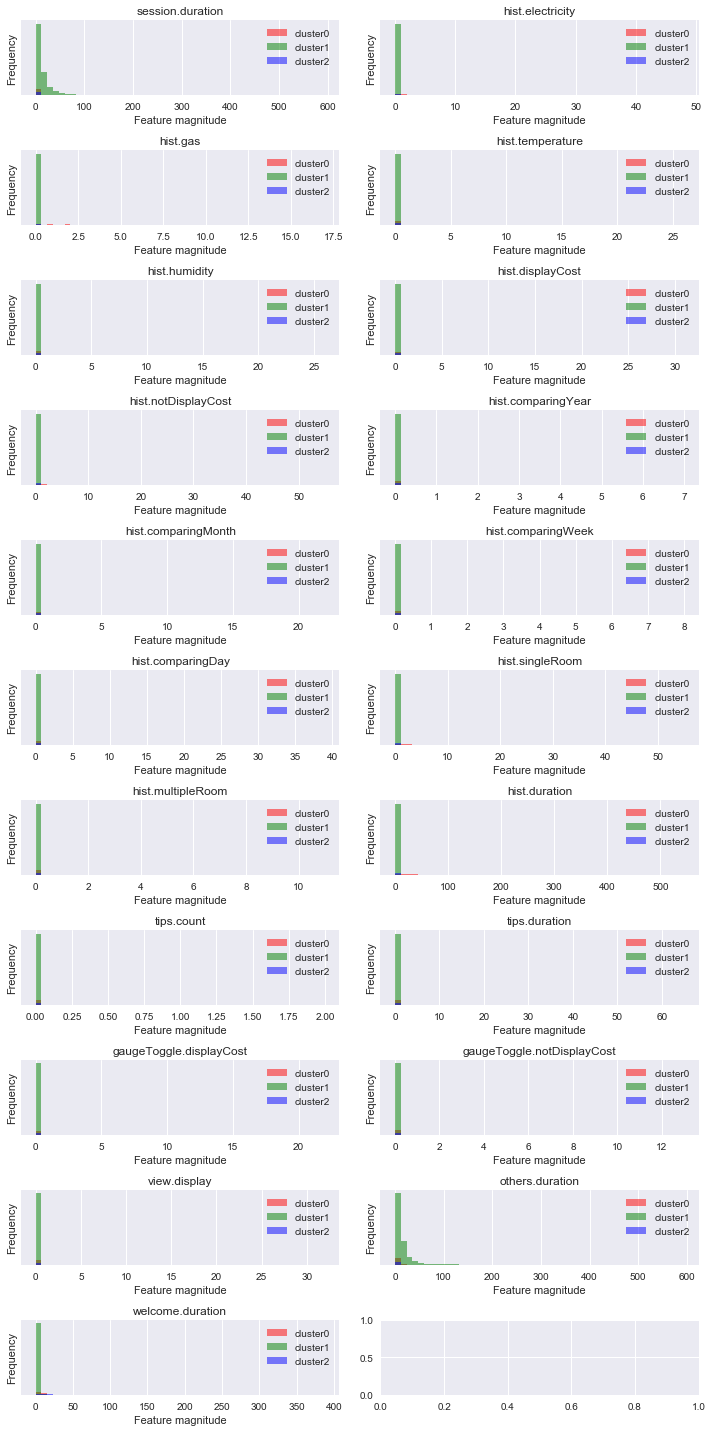

In [387]:
fig, axes = plt.subplots(11, 2, figsize=(10, 20))
cluster_0 = labeled_clickdata_dataset[labeled_clickdata_dataset['label'] == 0]
cluster_1 = labeled_clickdata_dataset[labeled_clickdata_dataset['label'] == 1]
cluster_2 = labeled_clickdata_dataset[labeled_clickdata_dataset['label'] == 2]

ax = axes.ravel()
for i in range(21):
    _, bins = np.histogram(labeled_clickdata_dataset[labeled_clickdata_dataset.columns[i]], bins=50)
    ax[i].hist(cluster_0[cluster_0.columns[i]], bins=bins, color='red', alpha=.5)
    ax[i].hist(cluster_1[cluster_1.columns[i]], bins=bins, color='green', alpha=.5)
    ax[i].hist(cluster_2[cluster_2.columns[i]], bins=bins, color='blue', alpha=.5)
    ax[i].set_title(labeled_clickdata_dataset.columns[i])
    ax[i].set_yticks(())
    ax[i].set_xlabel("Feature magnitude")
    ax[i].set_ylabel("Frequency")
    ax[i].legend(["cluster0", "cluster1", "cluster2"], loc="best")
fig.tight_layout()

### 3.1.2 K-means using time duration dimensions

In [28]:
input_filename = '../cleaned_data.csv'
columns = [
       'hist.duration',
       'tips.duration',
       'others.duration',
       'welcome.duration'
        ]
dataset = pd.read_csv(input_filename, encoding='utf-8', usecols=columns, engine='python', index_col=0)

In [29]:
# data transformation
duration_dataset = Normalizer().fit(dataset).transform(dataset)

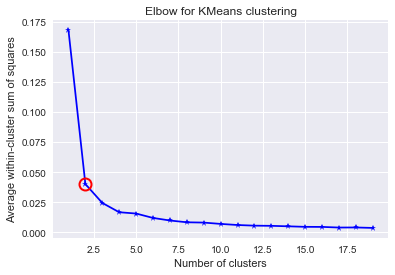

In [390]:
# K-means clustering 

# find the optimal cluster number k using 'elbow method'
K = range(1,20)
KM = [KMeans(n_clusters=k).fit(duration_dataset) for k in K]
centroids = [k.cluster_centers_ for k in KM]

D_k = [cdist(duration_dataset, cent, 'euclidean') for cent in centroids]
cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/duration_dataset.shape[0] for d in dist]

# Total with-in sum of square
wcss = [sum(d**2) for d in dist]
tss = sum(pdist(duration_dataset)**2)/duration_dataset.shape[0]
bss = tss-wcss

kIdx = 1 # point where rate of decline changes the most, so actually the number of clusters should be 3

# elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, avgWithinSS, 'b*-')
ax.plot(K[kIdx], avgWithinSS[kIdx], marker='o', markersize=12, 
markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow for KMeans clustering')
plt.show()

In [35]:
KM = KMeans(n_clusters=6).fit(duration_dataset)
labels = KM.predict(duration_dataset)
print('silhouette score of K-means clustering:', silhouette_score(duration_dataset, labels))
print('calinski harabaz score of K-means clustering:', calinski_harabaz_score(duration_dataset, labels))

silhouette score of K-means clustering: 0.943274475869
calinski harabaz score of K-means clustering: 179991.98788


In [31]:
label = pd.DataFrame(data=labels,columns=['label'])
dataset = clickdata_dataset.drop(['guiAccess.timestamp.start','guiAccess.timestamp.end','session.id','guiAccess.userid','guiAccess.homeid'], 1)
labeled_clickdata_dataset = pd.concat([dataset, label],axis=1)

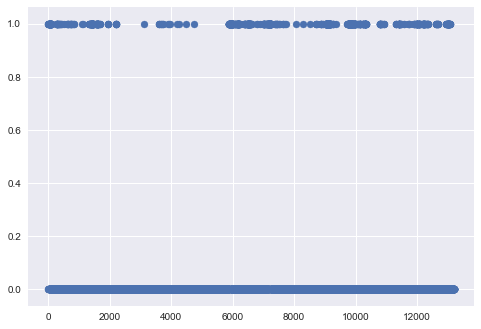

In [32]:
X = clickdata_dataset['session.id']
Y = label
plt.figure()
plt.scatter(X, Y)
plt.show()

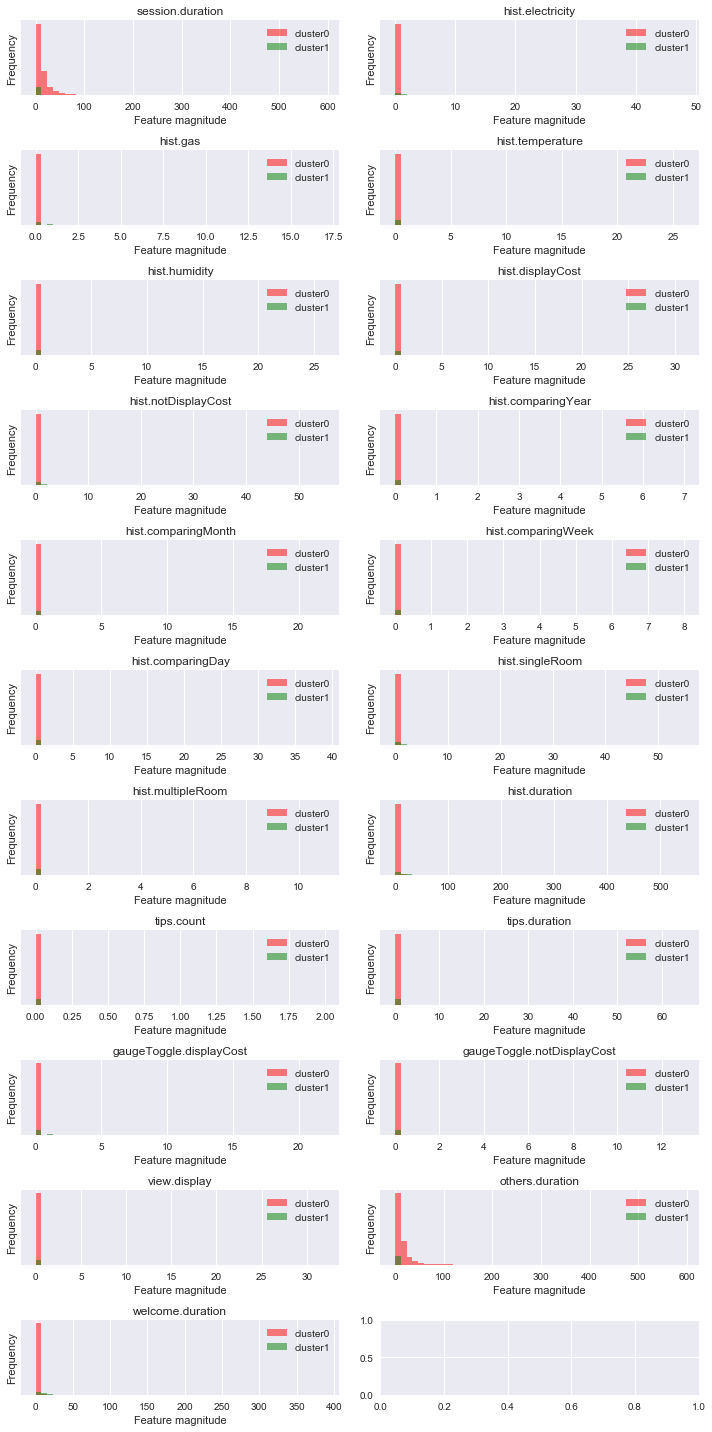

In [403]:
fig, axes = plt.subplots(11, 2, figsize=(10, 20))
cluster_0 = labeled_clickdata_dataset[labeled_clickdata_dataset['label'] == 0]
cluster_1 = labeled_clickdata_dataset[labeled_clickdata_dataset['label'] == 1]

ax = axes.ravel()
for i in range(21):
    _, bins = np.histogram(labeled_clickdata_dataset[labeled_clickdata_dataset.columns[i]], bins=50)
    ax[i].hist(cluster_0[cluster_0.columns[i]], bins=bins, color='red', alpha=.5)
    ax[i].hist(cluster_1[cluster_1.columns[i]], bins=bins, color='green', alpha=.5)
    ax[i].set_title(labeled_clickdata_dataset.columns[i])
    ax[i].set_yticks(())
    ax[i].set_xlabel("Feature magnitude")
    ax[i].set_ylabel("Frequency")
    ax[i].legend(["cluster0", "cluster1"], loc="best")
fig.tight_layout()

### 3.1.3 K-means using historical chart description dimensions

In [39]:
input_filename = '../cleaned_data.csv'
columns = [
       'hist.electricity',
       'hist.gas',
       'hist.temperature',
       'hist.humidity',
       'hist.displayCost',
       'hist.notDisplayCost',
       'hist.comparingYear',
       'hist.comparingMonth',
       'hist.comparingWeek',
       'hist.comparingDay',
       'hist.singleRoom',
       'hist.multipleRoom',
       'hist.duration'
        ]
hist_dataset = pd.read_csv(input_filename, encoding='utf-8', usecols=columns, engine='python', index_col=0)

In [40]:
# data transformation
hist_dataset = Normalizer().fit(hist_dataset).transform(hist_dataset)

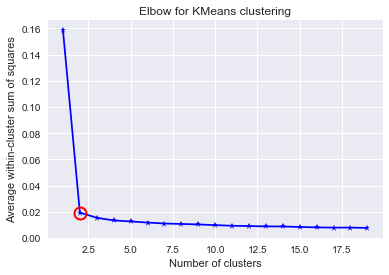

In [364]:
# K-means clustering 

# find the optimal cluster number k using 'elbow method'
K = range(1,20)
KM = [KMeans(n_clusters=k).fit(hist_dataset) for k in K]
centroids = [k.cluster_centers_ for k in KM]

D_k = [cdist(hist_dataset, cent, 'euclidean') for cent in centroids]
cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/hist_dataset.shape[0] for d in dist]

# Total with-in sum of square
wcss = [sum(d**2) for d in dist]
tss = sum(pdist(hist_dataset)**2)/hist_dataset.shape[0]
bss = tss-wcss

kIdx = 1 # point where rate of decline changes the most, so actually the number of clusters should be 3

# elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, avgWithinSS, 'b*-')
ax.plot(K[kIdx], avgWithinSS[kIdx], marker='o', markersize=12, 
markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow for KMeans clustering')
plt.show()

In [41]:
KM = KMeans(n_clusters=6).fit(hist_dataset)
labels = KM.predict(hist_dataset)
print('silhouette score of K-means clustering:', silhouette_score(hist_dataset, labels))
print('calinski harabaz score of K-means clustering:', calinski_harabaz_score(hist_dataset, labels))

silhouette score of K-means clustering: 0.938785403889
calinski harabaz score of K-means clustering: 92336.6675917


In [406]:
label = pd.DataFrame(data=labels,columns=['label'])
dataset = clickdata_dataset.drop(['guiAccess.timestamp.start','guiAccess.timestamp.end','session.id','guiAccess.userid','guiAccess.homeid'], 1)
labeled_clickdata_dataset = pd.concat([dataset, label],axis=1)

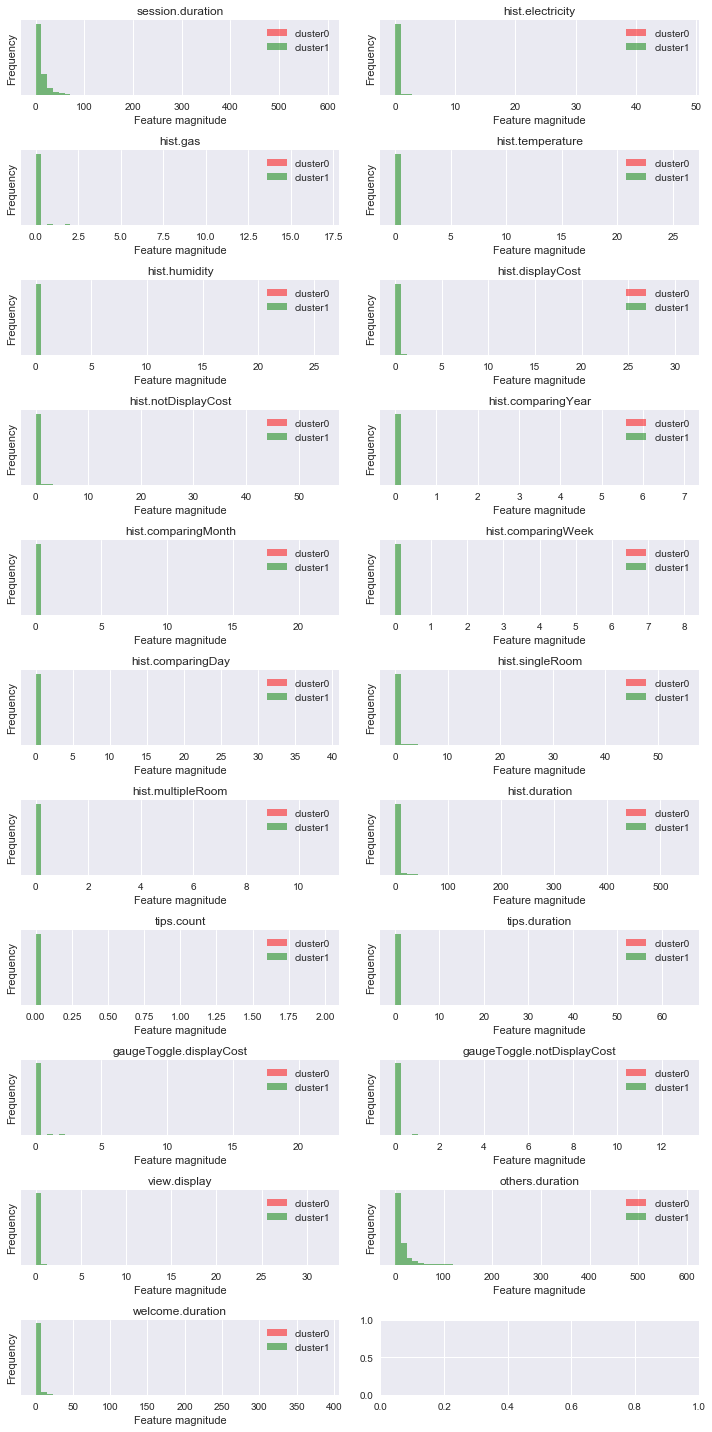

In [407]:
fig, axes = plt.subplots(11, 2, figsize=(10, 20))
cluster_0 = labeled_clickdata_dataset[labeled_clickdata_dataset['label'] == 0]
cluster_1 = labeled_clickdata_dataset[labeled_clickdata_dataset['label'] == 1]

ax = axes.ravel()
for i in range(21):
    _, bins = np.histogram(labeled_clickdata_dataset[labeled_clickdata_dataset.columns[i]], bins=50)
    ax[i].hist(cluster_0[cluster_0.columns[i]], bins=bins, color='red', alpha=.5)
    ax[i].hist(cluster_1[cluster_1.columns[i]], bins=bins, color='green', alpha=.5)
    ax[i].set_title(labeled_clickdata_dataset.columns[i])
    ax[i].set_yticks(())
    ax[i].set_xlabel("Feature magnitude")
    ax[i].set_ylabel("Frequency")
    ax[i].legend(["cluster0", "cluster1"], loc="best")
fig.tight_layout()

### 3.1.4 K-means using PCA selected dimensions

In [426]:
dataset = clickdata_dataset.drop(['guiAccess.timestamp.start','guiAccess.timestamp.end','session.id','guiAccess.userid','guiAccess.homeid'], 1)

# keep the first two principal components of the data
pca = PCA(n_components=3)
# fit PCA model to beast cancer data
pca.fit(dataset)

# transform data onto the first two principal components
dataset_pca = pca.transform(dataset)
print("Original shape: {}".format(str(dataset.shape)))
print("Reduced shape: {}".format(str(dataset_pca.shape)))

Original shape: (13210, 21)
Reduced shape: (13210, 3)


In [427]:
# data transformation
dataset_pca = Normalizer().fit(dataset_pca).transform(dataset_pca)
dataset_pca = pd.DataFrame(dataset_pca)

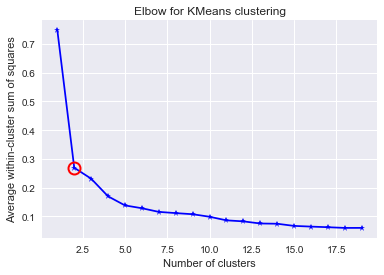

In [428]:
# K-means clustering 

# find the optimal cluster number k using 'elbow method'
K = range(1,20)
KM = [KMeans(n_clusters=k).fit(dataset_pca) for k in K]
centroids = [k.cluster_centers_ for k in KM]

D_k = [cdist(dataset_pca, cent, 'euclidean') for cent in centroids]
cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/dataset_pca.shape[0] for d in dist]

# Total with-in sum of square
wcss = [sum(d**2) for d in dist]
tss = sum(pdist(dataset_pca)**2)/dataset_pca.shape[0]
bss = tss-wcss

kIdx = 1 # point where rate of decline changes the most, so actually the number of clusters should be 3

# elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, avgWithinSS, 'b*-')
ax.plot(K[kIdx], avgWithinSS[kIdx], marker='o', markersize=12, 
markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow for KMeans clustering')
plt.show()

In [429]:
KM = KMeans(n_clusters=2).fit(dataset_pca)
labels = KM.predict(dataset_pca)
print('silhouette score of K-means clustering:', silhouette_score(dataset_pca, labels))
print('calinski harabaz score of K-means clustering:', calinski_harabaz_score(dataset_pca, labels))

silhouette score of K-means clustering: 0.779617929872
calinski harabaz score of K-means clustering: 44015.7505082


In [430]:
label = pd.DataFrame(data=labels,columns=['label'])
dataset = clickdata_dataset.drop(['guiAccess.timestamp.start','guiAccess.timestamp.end','session.id','guiAccess.userid','guiAccess.homeid'], 1)
labeled_clickdata_dataset = pd.concat([dataset, label],axis=1)

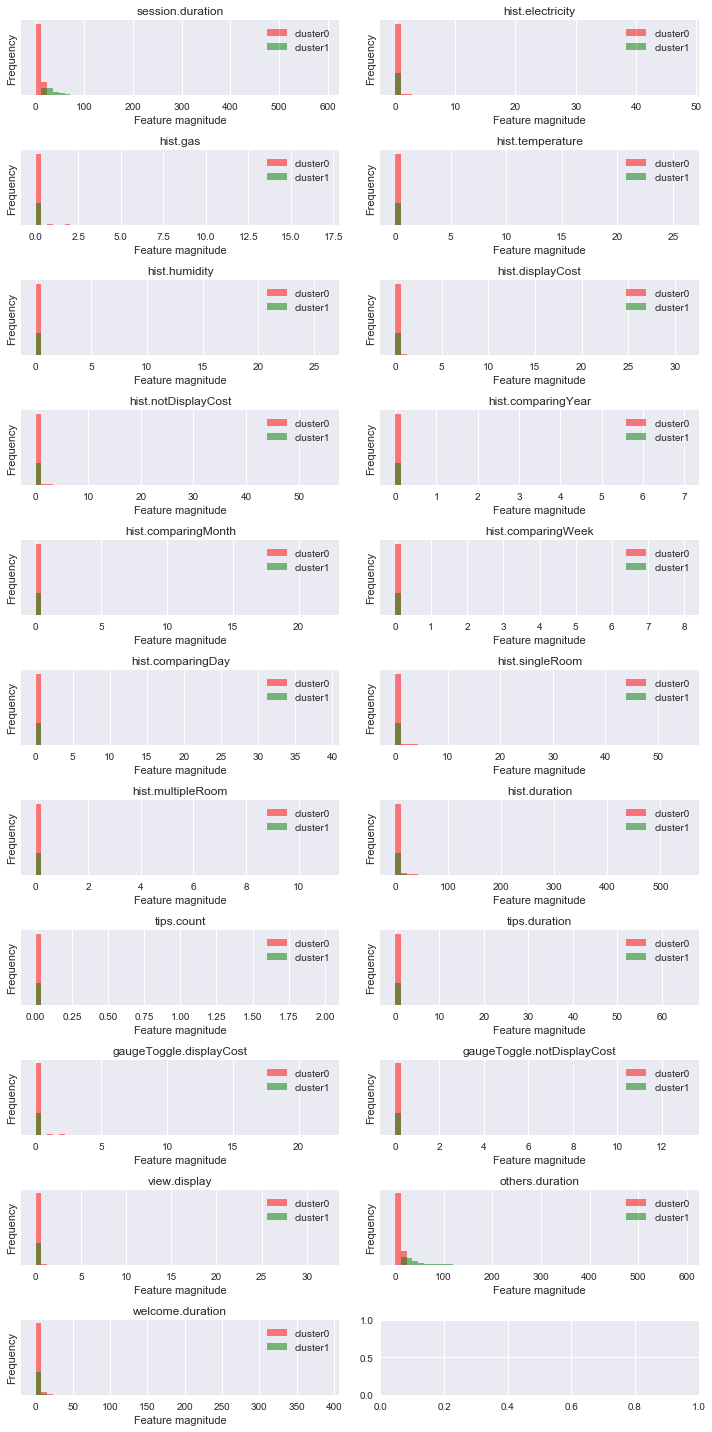

In [431]:
fig, axes = plt.subplots(11, 2, figsize=(10, 20))
cluster_0 = labeled_clickdata_dataset[labeled_clickdata_dataset['label'] == 0]
cluster_1 = labeled_clickdata_dataset[labeled_clickdata_dataset['label'] == 1]

ax = axes.ravel()
for i in range(21):
    _, bins = np.histogram(labeled_clickdata_dataset[labeled_clickdata_dataset.columns[i]], bins=50)
    ax[i].hist(cluster_0[cluster_0.columns[i]], bins=bins, color='red', alpha=.5)
    ax[i].hist(cluster_1[cluster_1.columns[i]], bins=bins, color='green', alpha=.5)
    ax[i].set_title(labeled_clickdata_dataset.columns[i])
    ax[i].set_yticks(())
    ax[i].set_xlabel("Feature magnitude")
    ax[i].set_ylabel("Frequency")
    ax[i].legend(["cluster0", "cluster1"], loc="best")
fig.tight_layout()

## 3.2 Hierarchical clustering 

In [35]:
dataset = clickdata_dataset.drop(['guiAccess.timestamp.start','guiAccess.timestamp.end','session.id','guiAccess.userid','guiAccess.homeid'], 1)

In [78]:
columns = [
       #'session.id',
       'session.duration',
       #'guiAccess.homeid', 
       #'guiAccess.userid', 
       #'guiAccess.timestamp.start',
       #'guiAccess.timestamp.end',
       'hist.electricity',
       'hist.gas',
       #'hist.temperature',
       #'hist.humidity',
       'hist.displayCost',
       'hist.notDisplayCost',
       #'hist.comparingYear',
       #'hist.comparingMonth',
       #'hist.comparingWeek',
       #'hist.comparingDay',
       #'hist.singleRoom',
       #'hist.multipleRoom',
       'hist.duration',
       'tips.count',
       'tips.duration',
       'gaugeToggle.displayCost',
       'gaugeToggle.notDisplayCost',
       #'view.display',
       'others.duration',
       'welcome.duration'
        ]

input_filename = '../cleaned_data.csv'
clickdata_dataset = pd.read_csv(input_filename, encoding='utf-8', usecols=columns, engine='python')

In [238]:
input_filename = '../cleaned_data.csv'
clickdata_dataset = pd.read_csv(input_filename, encoding='utf-8', usecols=columns[:2], engine='python')
dataset_Normalizer = Normalizer().fit(clickdata_dataset).transform(clickdata_dataset)

In [240]:
# Hierarchical clustering
sys.setrecursionlimit(10000)
# find the optimal cluster number k using 'ward method'
data_dist = pdist(dataset_Normalizer,'euclidean') # computing the euclidean distance
data_link = linkage(data_dist, method='ward') # computing the linkage

dendrogram(data_link)
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.suptitle('Samples clustering', fontweight='bold', fontsize=14)
plt.show()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [81]:
input_filename = '../cleaned_data.csv'
dataset = pd.read_csv(input_filename, encoding='utf-8', engine='python')

In [82]:
# find the optimal cluster number k using 'ward method'
data_dist = pdist(dataset_Normalizer,'euclidean') # computing the euclidean distance
data_link = linkage(data_dist, method='ward') # computing the linkage


labels = fcluster(data_link, t=15, criterion='distance')

label = pd.DataFrame(data=labels,columns=['label'])
labeled_clickdata_dataset = pd.concat([dataset, label],axis=1)

print('silhouette score of K-means clustering:', silhouette_score(dataset_Normalizer, labels))
print('calinski harabaz score of K-means clustering:', calinski_harabaz_score(dataset_Normalizer, labels))

silhouette score of K-means clustering: 0.934260154962
calinski harabaz score of K-means clustering: 41570.0915118


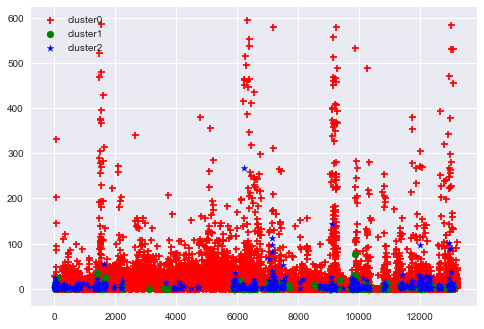

In [87]:
cluster_0 = labeled_clickdata_dataset[labeled_clickdata_dataset['label'] == 1]
cluster_1 = labeled_clickdata_dataset[labeled_clickdata_dataset['label'] == 2]
cluster_2 = labeled_clickdata_dataset[labeled_clickdata_dataset['label'] == 3]

plt.figure()
c0 = plt.scatter(cluster_0['session.id'],cluster_0['session.duration'],c='r',marker='+')
c1 = plt.scatter(cluster_1['session.id'],cluster_1['session.duration'],c='g',marker='o')
c2 = plt.scatter(cluster_2['session.id'],cluster_2['session.duration'],c='b',marker='*')
plt.legend([c0, c1, c2], ['cluster0', 'cluster1','cluster2'])
plt.show()

### 3.2.1 Hierarchical clustering using all the dimensions

In [36]:
dataset_Normalizer = Normalizer().fit(dataset).transform(dataset)

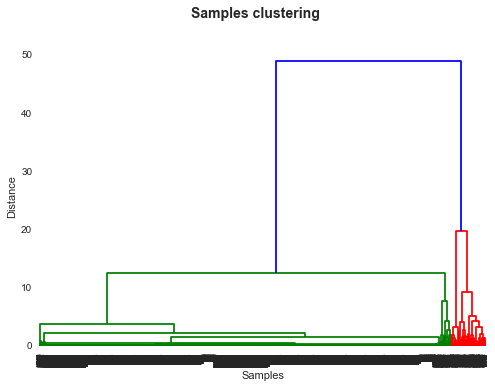

In [37]:
# Hierarchical clustering

# find the optimal cluster number k using 'ward method'
data_dist = pdist(dataset_Normalizer,'euclidean') # computing the euclidean distance
data_link = linkage(data_dist, method='ward') # computing the linkage

dendrogram(data_link)
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.suptitle('Samples clustering', fontweight='bold', fontsize=14)
plt.show()

In [38]:
labels = fcluster(data_link, t=20, criterion='distance')

label = pd.DataFrame(data=labels,columns=['label'])
labeled_click_dataset = pd.concat([dataset, label],axis=1)

print('silhouette score of K-means clustering:', silhouette_score(dataset_Normalizer, labels))
print('calinski harabaz score of K-means clustering:', calinski_harabaz_score(dataset_Normalizer, labels))

silhouette score of K-means clustering: 0.921772315511
calinski harabaz score of K-means clustering: 32664.4923394


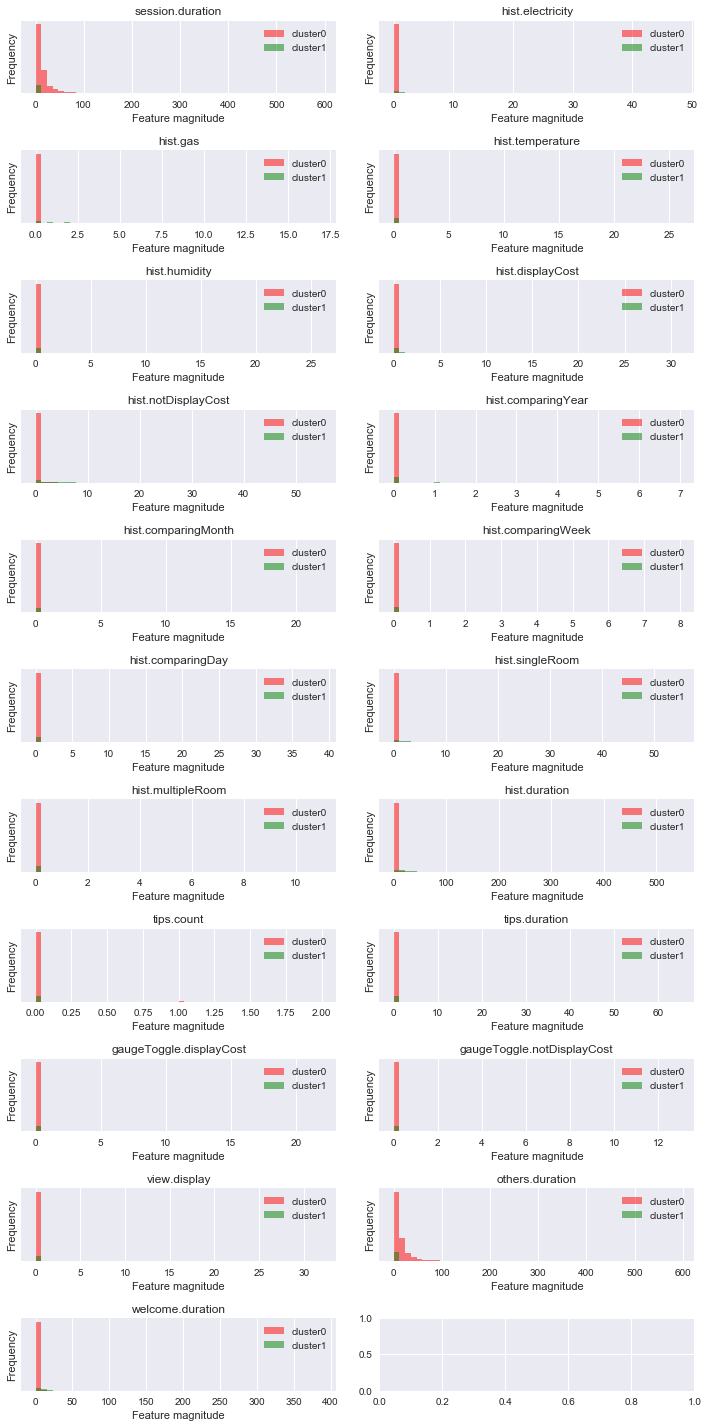

In [41]:
fig, axes = plt.subplots(11, 2, figsize=(10, 20))
cluster_0 = labeled_click_dataset[labeled_click_dataset['label'] == 1]
cluster_1 = labeled_click_dataset[labeled_click_dataset['label'] == 2]

ax = axes.ravel()
for i in range(21):
    _, bins = np.histogram(labeled_click_dataset[labeled_click_dataset.columns[i]], bins=50)
    ax[i].hist(cluster_0[cluster_0.columns[i]], bins=bins, color='red', alpha=.5)
    ax[i].hist(cluster_1[cluster_1.columns[i]], bins=bins, color='green', alpha=.5)
    ax[i].set_title(labeled_click_dataset.columns[i])
    ax[i].set_yticks(())
    ax[i].set_xlabel("Feature magnitude")
    ax[i].set_ylabel("Frequency")
    ax[i].legend(["cluster0", "cluster1"], loc="best")
fig.tight_layout()

### 3.2.2 Hierarchical clustering using time duration dimensions

In [12]:
columns = [
       'session.id',
       'guiAccess.homeid', 
       'guiAccess.userid', 
       'guiAccess.timestamp.start',
       'guiAccess.timestamp.end',
       'hist.electricity',
       'hist.gas',
       'hist.temperature',
       'hist.humidity',
       'hist.displayCost',
       'hist.notDisplayCost',
       'hist.comparingYear',
       'hist.comparingMonth',
       'hist.comparingWeek',
       'hist.comparingDay',
       'hist.singleRoom',
       'hist.multipleRoom',
       'tips.count',
       'gaugeToggle.displayCost',
       'gaugeToggle.notDisplayCost',
       'view.display'
        ]
dataset = clickdata_dataset.drop(columns, 1)

In [13]:
# data transformation
duration_dataset = Normalizer().fit(dataset).transform(dataset)

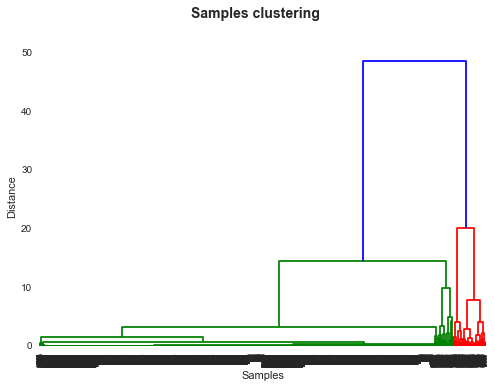

In [14]:
# Hierarchical clustering

# find the optimal cluster number k using 'ward method'
data_dist = pdist(duration_dataset,'euclidean') # computing the euclidean distance
data_link = linkage(data_dist, method='ward') # computing the linkage

dendrogram(data_link)
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.suptitle('Samples clustering', fontweight='bold', fontsize=14)
plt.show()

In [31]:
labels = fcluster(data_link, t=25, criterion='distance')

label = pd.DataFrame(data=labels,columns=['label'])
dataset = clickdata_dataset.drop(['guiAccess.timestamp.start','guiAccess.timestamp.end','session.id','guiAccess.userid','guiAccess.homeid'], 1)
labeled_click_dataset = pd.concat([dataset, label],axis=1)

print('silhouette score of K-means clustering:', silhouette_score(dataset_Normalizer, labels))
print('calinski harabaz score of K-means clustering:', calinski_harabaz_score(dataset_Normalizer, labels))

silhouette score of K-means clustering: 0.917087291373
calinski harabaz score of K-means clustering: 29476.3937985


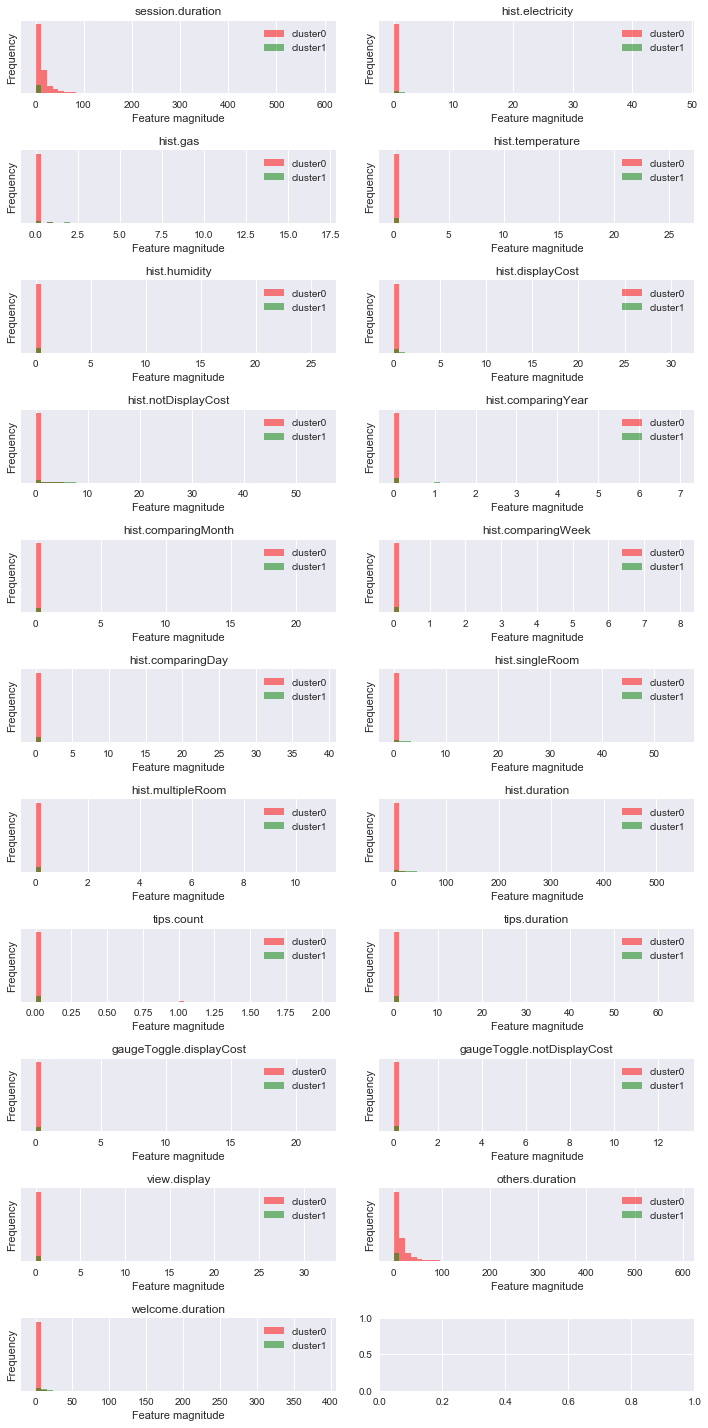

In [34]:
fig, axes = plt.subplots(11, 2, figsize=(10, 20))
cluster_0 = labeled_click_dataset[labeled_click_dataset['label'] == 1]
cluster_1 = labeled_click_dataset[labeled_click_dataset['label'] == 2]

ax = axes.ravel()
for i in range(21):
    _, bins = np.histogram(labeled_click_dataset[labeled_click_dataset.columns[i]], bins=50)
    ax[i].hist(cluster_0[cluster_0.columns[i]], bins=bins, color='red', alpha=.5)
    ax[i].hist(cluster_1[cluster_1.columns[i]], bins=bins, color='green', alpha=.5)
    ax[i].set_title(labeled_click_dataset.columns[i])
    ax[i].set_yticks(())
    ax[i].set_xlabel("Feature magnitude")
    ax[i].set_ylabel("Frequency")
    ax[i].legend(["cluster0", "cluster1"], loc="best")
fig.tight_layout()

### 3.2.3 Hierarchical clustering using historical chart description dimensions

In [247]:
columns = [
       'session.id',
       'guiAccess.homeid', 
       'guiAccess.userid', 
       'guiAccess.timestamp.start',
       'guiAccess.timestamp.end',
       'tips.count',
       'tips.duration',
       'gaugeToggle.displayCost',
       'gaugeToggle.notDisplayCost',
       'view.display',
       'others.duration',
       'welcome.duration'
        ]
dataset = clickdata_dataset.drop(columns, 1)

ValueError: labels ['session.id' 'guiAccess.homeid' 'guiAccess.userid'
 'guiAccess.timestamp.start' 'guiAccess.timestamp.end' 'tips.count'
 'tips.duration' 'gaugeToggle.displayCost' 'gaugeToggle.notDisplayCost'
 'view.display' 'others.duration' 'welcome.duration'] not contained in axis

In [248]:
dataset = Normalizer().fit(dataset).transform(dataset)

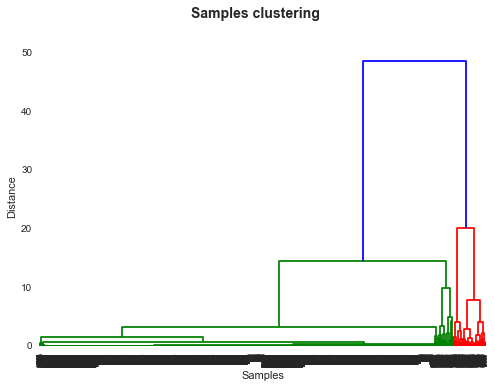

In [44]:
# Hierarchical clustering

# find the optimal cluster number k using 'ward method'
data_dist = pdist(duration_dataset,'euclidean') # computing the euclidean distance
data_link = linkage(data_dist, method='ward') # computing the linkage

dendrogram(data_link)
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.suptitle('Samples clustering', fontweight='bold', fontsize=14)
plt.show()

In [246]:
labels = fcluster(data_link, t=3, criterion='maxclust')
label = pd.DataFrame(data=labels,columns=['label'])
dataset = clickdata_dataset.drop(['guiAccess.timestamp.start','guiAccess.timestamp.end','session.id','guiAccess.userid','guiAccess.homeid'], 1)
labeled_click_dataset = pd.concat([dataset, label],axis=1)

print('silhouette score of K-means clustering:', silhouette_score(dataset_Normalizer, labels))
print('calinski harabaz score of K-means clustering:', calinski_harabaz_score(dataset_Normalizer, labels))

ValueError: labels ['guiAccess.timestamp.start' 'guiAccess.timestamp.end' 'session.id'
 'guiAccess.userid' 'guiAccess.homeid'] not contained in axis

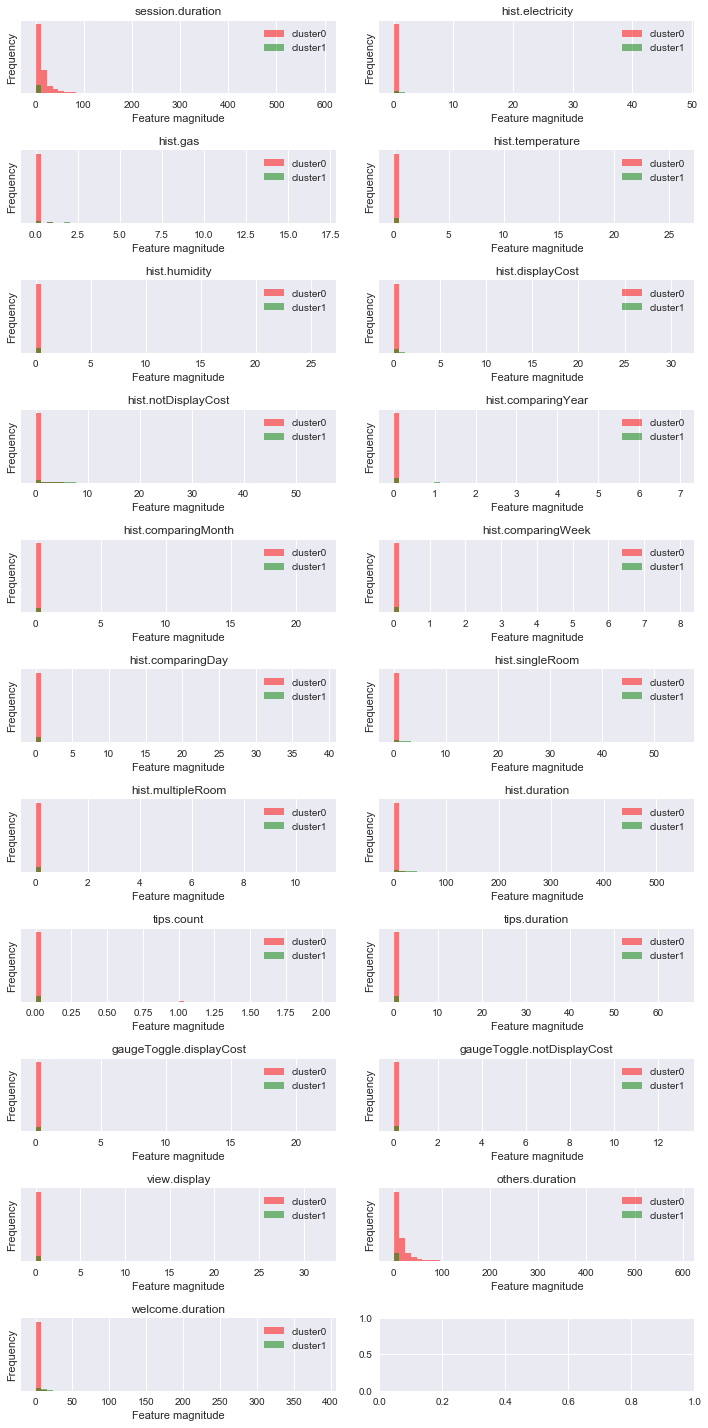

In [46]:
fig, axes = plt.subplots(11, 2, figsize=(10, 20))
cluster_0 = labeled_click_dataset[labeled_click_dataset['label'] == 1]
cluster_1 = labeled_click_dataset[labeled_click_dataset['label'] == 2]

ax = axes.ravel()
for i in range(21):
    _, bins = np.histogram(labeled_click_dataset[labeled_click_dataset.columns[i]], bins=50)
    ax[i].hist(cluster_0[cluster_0.columns[i]], bins=bins, color='red', alpha=.5)
    ax[i].hist(cluster_1[cluster_1.columns[i]], bins=bins, color='green', alpha=.5)
    ax[i].set_title(labeled_click_dataset.columns[i])
    ax[i].set_yticks(())
    ax[i].set_xlabel("Feature magnitude")
    ax[i].set_ylabel("Frequency")
    ax[i].legend(["cluster0", "cluster1"], loc="best")
fig.tight_layout()

### 3.2.4 Hierarchical clustering using pca picked dimensions

In [47]:
dataset = clickdata_dataset.drop(['guiAccess.timestamp.start','guiAccess.timestamp.end','session.id','guiAccess.userid','guiAccess.homeid'], 1)

# keep the first two principal components of the data
pca = PCA(n_components=5)
# fit PCA model to beast cancer data
pca.fit(dataset)

# transform data onto the first two principal components
dataset_pca = pca.transform(dataset)
print("Original shape: {}".format(str(dataset.shape)))
print("Reduced shape: {}".format(str(dataset_pca.shape)))

Original shape: (13210, 21)
Reduced shape: (13210, 5)


In [48]:
# data transformation
dataset_pca = Normalizer().fit(dataset_pca).transform(dataset_pca)
dataset_pca = pd.DataFrame(dataset_pca)

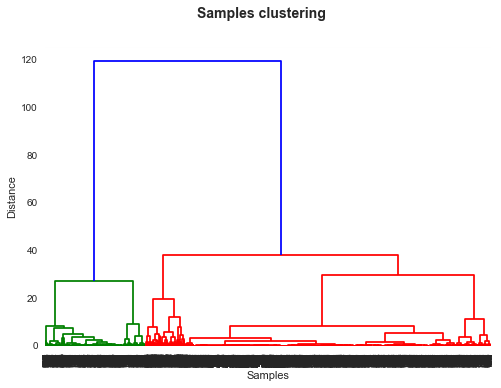

In [49]:
# Hierarchical clustering

# find the optimal cluster number k using 'ward method'
data_dist = pdist(dataset_pca,'euclidean') # computing the euclidean distance
data_link = linkage(data_dist, method='ward') # computing the linkage

dendrogram(data_link)
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.suptitle('Samples clustering', fontweight='bold', fontsize=14)
plt.show()

In [50]:
labels = fcluster(data_link, t=30, criterion='distance')

label = pd.DataFrame(data=labels,columns=['label'])
dataset = clickdata_dataset.drop(['guiAccess.timestamp.start','guiAccess.timestamp.end','session.id','guiAccess.userid','guiAccess.homeid'], 1)
labeled_click_dataset = pd.concat([dataset, label],axis=1)

print('silhouette score of K-means clustering:', silhouette_score(dataset_pca, labels))
print('calinski harabaz score of K-means clustering:', calinski_harabaz_score(dataset_pca, labels))

silhouette score of K-means clustering: 0.720125052521
calinski harabaz score of K-means clustering: 32898.2634945


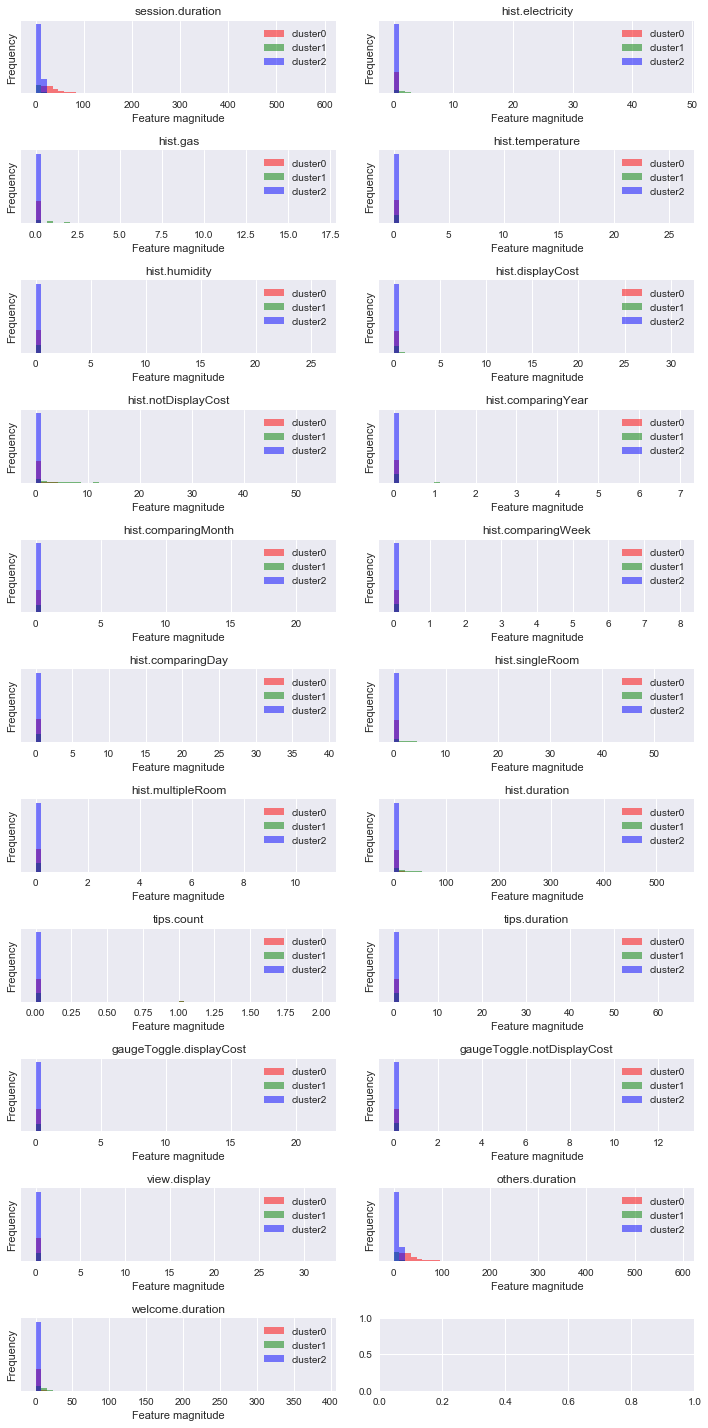

In [51]:
fig, axes = plt.subplots(11, 2, figsize=(10, 20))
cluster_0 = labeled_click_dataset[labeled_click_dataset['label'] == 1]
cluster_1 = labeled_click_dataset[labeled_click_dataset['label'] == 2]
cluster_2 = labeled_click_dataset[labeled_click_dataset['label'] == 3]

ax = axes.ravel()
for i in range(21):
    _, bins = np.histogram(labeled_click_dataset[labeled_click_dataset.columns[i]], bins=50)
    ax[i].hist(cluster_0[cluster_0.columns[i]], bins=bins, color='red', alpha=.5)
    ax[i].hist(cluster_1[cluster_1.columns[i]], bins=bins, color='green', alpha=.5)
    ax[i].hist(cluster_2[cluster_2.columns[i]], bins=bins, color='blue', alpha=.5)
    ax[i].set_title(labeled_click_dataset.columns[i])
    ax[i].set_yticks(())
    ax[i].set_xlabel("Feature magnitude")
    ax[i].set_ylabel("Frequency")
    ax[i].legend(["cluster0", "cluster1", "cluster2"], loc="best")
fig.tight_layout()

## 3.3 Gaussian mixture model clustering 

In [107]:
columns = [
       #'session.id',
       'session.duration',
       #'guiAccess.homeid', 
       #'guiAccess.userid', 
       #'guiAccess.timestamp.start',
       #'guiAccess.timestamp.end',
       'hist.electricity',
       'hist.gas',
       #'hist.temperature',
       #'hist.humidity',
       'hist.displayCost',
       'hist.notDisplayCost',
       #'hist.comparingYear',
       #'hist.comparingMonth',
       #'hist.comparingWeek',
       #'hist.comparingDay',
       #'hist.singleRoom',
       #'hist.multipleRoom',
       'hist.duration',
       'tips.count',
       'tips.duration',
       'gaugeToggle.displayCost',
       'gaugeToggle.notDisplayCost',
       #'view.display',
       'others.duration',
       'welcome.duration'
        ]

input_filename = '../cleaned_data.csv'
dataset_Normalizer = pd.read_csv(input_filename, encoding='utf-8', usecols=columns, engine='python')
#dataset_Normalizer = Normalizer().fit(clickdata_dataset).transform(clickdata_dataset)

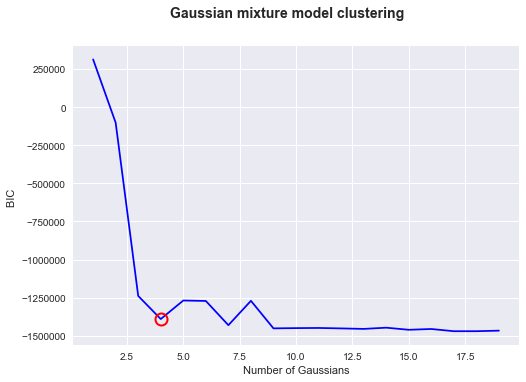

In [108]:
# Gaussian mixture model clustering 

# find the optimal cluster number k using BIC
bic = np.zeros(19)
n = range(1,20)
models = []
#loop through each number of Gaussians and compute the BIC, and save the model
for i,j in enumerate(n):
    #create mixture model with j components
    gmm = GaussianMixture(n_components=j)
    #fit it to the data
    gmm.fit(dataset_Normalizer)
    #compute the BIC for this model
    bic[i] = gmm.bic(dataset_Normalizer)
    #add the best-fit model with j components to the list of models
    models.append(gmm)

plt.plot(n,bic,'-o',markevery=[3],color='b',markersize=12, 
         markeredgewidth=2, markeredgecolor='r', markerfacecolor='None') # Not sure 3
plt.xlabel('Number of Gaussians')
plt.ylabel('BIC ')
plt.suptitle('Gaussian mixture model clustering ', fontweight='bold', fontsize=14)
plt.show()

In [ ]:
input_filename = '../cleaned_data.csv'
dataset = pd.read_csv(input_filename, encoding='utf-8', usecols=columns[:3], engine='python')
transformed_dataset = Normalizer().fit(dataset).transform(dataset)
# Gaussian mixture model clustering based on total number of page loads
gmm = GaussianMixture(n_components=3).fit(transformed_dataset)
labels = gmm.predict(transformed_dataset)

print('silhouette score of K-means clustering:', silhouette_score(transformed_dataset, labels))
print('calinski harabaz score of K-means clustering:', calinski_harabaz_score(transformed_dataset, labels))

In [202]:
# Gaussian mixture model clustering based on total number of page loads
gmm = GaussianMixture(n_components=3).fit(transformed_dataset)
labels = gmm.predict(transformed_dataset)

print('silhouette score of K-means clustering:', silhouette_score(transformed_dataset, labels))
print('calinski harabaz score of K-means clustering:', calinski_harabaz_score(transformed_dataset, labels))

silhouette score of K-means clustering: 0.904513288594
calinski harabaz score of K-means clustering: 10890.3324754


In [111]:
label = pd.DataFrame(data=labels,columns=['label'])
labeled_clickdata_dataset = pd.concat([dataset, label],axis=1)

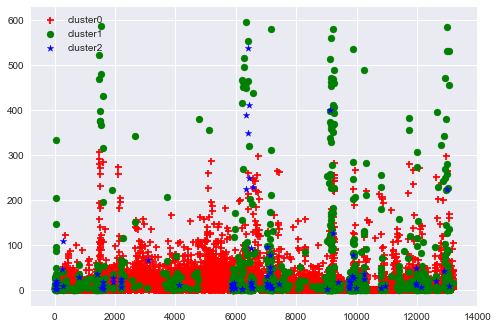

In [112]:
cluster_0 = labeled_clickdata_dataset[labeled_clickdata_dataset['label'] == 0]
cluster_1 = labeled_clickdata_dataset[labeled_clickdata_dataset['label'] == 1]
cluster_2 = labeled_clickdata_dataset[labeled_clickdata_dataset['label'] == 2]

plt.figure()
c0 = plt.scatter(cluster_0['session.id'],cluster_0['session.duration'],c='r',marker='+')
c1 = plt.scatter(cluster_1['session.id'],cluster_1['session.duration'],c='g',marker='o')
c2 = plt.scatter(cluster_2['session.id'],cluster_2['session.duration'],c='b',marker='*')
plt.legend([c0, c1, c2], ['cluster0', 'cluster1','cluster2'])
plt.show()

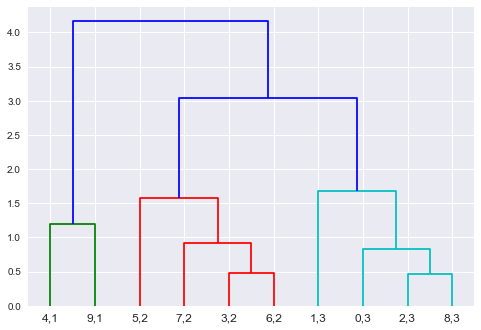

In [244]:
import scipy
import scipy.cluster.hierarchy as sch
import matplotlib.pylab as plt

n=10
k=3
X = scipy.randn(n,2)
d = sch.distance.pdist(X)
Z= sch.linkage(d,method='complete')
T = fcluster(Z, k, 'maxclust')

# calculate labels
labels=list('' for i in range(n))
for i in range(n):
    labels[i]=str(i)+ ',' + str(T[i])

# calculate color threshold
ct=Z[-(k-1),2]  

#plot
P =sch.dendrogram(Z,labels=labels,color_threshold=ct)
plt.show()